## Setting the scene - Project Overview
### State the high-level overview of the project, including the background information such as problem domain, project origin, and related data sets or input data.
In a land far, far away, somewhere in a hytte on the southern slopes of the Jotunheimen nasjonalpark, imagine yourself working on a data team for a popular digital music streaming service, similar to Spotify.
You company collects loads of data on free and paying users each time they interact with the service. 
For example, users can play a song, logout, like, hear an ad (if they are in the free-tier group), downgrade, where the users are located, and so on and so forth.
Part of your job is to make sure that the users love the service. 

## Problem Statement
### Define the problem to be solved.
Your boss asks you to make models to identify which users are likely to churn based on the collected data. 
If we can do this accurately, we can save our company millions in revenue - and probably get a promotion. 
How do you approach the problem?
Here's what I did.

## Metrics
### Define the metrics to measure the results and justifications to use the metrics.
After spliting the full dataset into train, test, and validation sets, I tested several machine learning methods on the training set. 
I then evaluated the accuracy of the various tuned models based on the validation set. 
Since the number of churned users is fairly small, I used the F1 score to optimize. 

## Project steps: 
- Load Data into Spark
- Explore & Clean Data
- Create Features
- Build Models
- Predict Churn

## Learnings
Demonstrating mastery of Spark's scalable data manipulation and machine learning. 
Built a useful model with a massive dataset.

You'll learn how to manipulate large and realistic datasets with Spark to engineer relevant features for predicting churn. You'll learn how to use Spark MLlib to build machine learning models with large datasets, far beyond what could be done with non-distributed technologies like scikit-learn.

## Career Relevance
Predicting churn rates is a challenging and common problem that data scientists and analysts regularly encounter in any customer-facing business. Additionally, the ability to efficiently manipulate large datasets with Spark is one of the highest-demand skills in the field of data.

## Essential Skills
Load large datasets into Spark and manipulate them using Spark SQL and Spark Dataframes
Use the machine learning APIs within Spark ML to build and tune models
Integrate the skills you've learned in the Spark course and the Data Scientist Nanodegree program


# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import IntegerType, DateType, StringType, TimestampType, FloatType
from pyspark.sql.functions import desc, udf, isnull, isnan, when, count, col, countDistinct, to_date
from pyspark.sql.functions import sum as Fsum

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, PCA
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

from py4j.java_gateway import JavaGateway
gateway = JavaGateway()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime

In [2]:
spark = SparkSession \
    .builder \
    .appName("Music_App") \
    .config("spark.memory.offHeap.enabled", "true") \
    .config("spark.memory.offHeap.size","4g") \
    .getOrCreate()

In [3]:
print( "spark version=" ,SparkSession.builder.appName("test").getOrCreate().version)

spark version= 3.1.2


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# path = "mini_sparkify_event_data.json"
path = "sparkify_log_small.json"
data = spark.read.json(path)
data

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
def describe_data_prelim_analysis(df):
    '''
    Display important statistics about the DataFrame 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Print statistics about 'df'
    '''

    print(f"DataFrame shape: \trows={df.count()}, \tcolumns={len(df.columns)}")
    print(f'\nUnique values per column:')
    df.select([countDistinct(col(c)).alias(c) for c in df.columns]).show()
    unique_per_column = df.select([countDistinct(col(c)).alias(c) for c in df.columns]).collect()

    print(f'\nUnique page actions:')
    df.groupBy("page").agg(count("page")).show(n = df.groupBy("page").agg(count("page")).count() + 1, truncate=False)
    unique_for_page_column = df.groupBy("page").agg(count("page")).collect()
    
    return unique_per_column, unique_for_page_column

In [6]:
# Preliminary analysis
unique_per_column, unique_for_page_column = describe_data_prelim_analysis(data) 

DataFrame shape: 	rows=54499, 	columns=18

Unique values per column:
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+-----+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status|   ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+-----+---------+------+
|  9088|   3|      118|     2|         1100|     111|  9741|    2|      87|     2|  20|         133|      719|21479|     3|53211|       46|   134|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+-----+---------+------+


Unique page actions:
+-------------------------+-----------+
|page                     |count(page)|
+-------------------------+-----------+
|Cancel                   |9          |
|Submit Downg

In [7]:
data.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+------------------+-----+--------------------+------+-------+--------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|            length|level|            location|method|   page|        registration|         sessionId|                song|           status|                  ts|           userAgent|            userId|
+-------+------------------+----------+---------+------+------------------+--------+------------------+-----+--------------------+------+-------+--------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+
|  count|             43189|     54499|    52853| 52853|             54499|   52853|             43189|54499|               52853| 54499|  544

In [8]:
for field in data.schema.fields:
    if field.name in ['ts', 'registration', 'sessionId', 'userId', 'length', 'itemInSession', 'artist', 'firstName', 'lastName', 'location']:
        None
    else:
        data.select(field.name).distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
| Logged In|
+----------+

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+------+
|method|
+------+
|   PUT|
|   GET|
+------+

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|               Login|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+

+--------------------+
|                song|
+--------------------+
|Never Gonna Be Al...|
|         TULENLIEKKI|
|      Underwaterboys|
|Saor (Free)/News ...|
|               New E|
|Th

In [9]:
data.select('location').distinct().show(truncate=False)

+-----------------------------------------+
|location                                 |
+-----------------------------------------+
|Gainesville, FL                          |
|Atlantic City-Hammonton, NJ              |
|Deltona-Daytona Beach-Ormond Beach, FL   |
|San Diego-Carlsbad, CA                   |
|Kingsport-Bristol-Bristol, TN-VA         |
|New Haven-Milford, CT                    |
|Corpus Christi, TX                       |
|Dubuque, IA                              |
|Las Vegas-Henderson-Paradise, NV         |
|Indianapolis-Carmel-Anderson, IN         |
|Seattle-Tacoma-Bellevue, WA              |
|Winston-Salem, NC                        |
|Bakersfield, CA                          |
|Los Angeles-Long Beach-Anaheim, CA       |
|Minneapolis-St. Paul-Bloomington, MN-WI  |
|San Francisco-Oakland-Hayward, CA        |
|Phoenix-Mesa-Scottsdale, AZ              |
|Allentown-Bethlehem-Easton, PA-NJ        |
|Miami-Fort Lauderdale-West Palm Beach, FL|
|Selma, AL                      

In [10]:
data.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [11]:
def describe_data_cleanup(df, cleanup=0):
    '''
    Display important statistics about the DataFrame before & after data cleanup
    INPUT
        df - spark or pandas DataFrame
        cleanup - String to print ahead of displayed statistics; bool
    OUTPUT
        Print statistics about 'df'
    '''

    if cleanup:
        print(f'Data AFTER clean-up:\n')
    else:
        print(f'Data BEFORE clean-up:\n')
    
    df.printSchema()

    print(f"DataFrame shape:\nrows={df.count()}, columns={len(df.columns)}")
    print(f"Unique userId's = {df.select('userId').dropDuplicates().count()}")
    # print(f"Unique sessionId's = {df.select('sessionId').dropDuplicates().count()}")

    print(f'\nUnique page actions:')
    df.groupBy("page").agg(count("page")).show()

    print(f'\nNull, empty string, nan values per column:')
    df.select([count(when(
        col(c).contains('None') | \
        col(c).contains('NULL') | \
        (col(c) == '' ) | \
        col(c).isNull() | \
        isnan(c), c 
        )).alias(c) for c in df.columns]).show()

def clean_up_data(df):
    '''
    Clean up DataFrame by dropping unused columns & rows that have empty or na values in the specified columns
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        df_clean - cleaned DataFrame
    '''

    df_clean = df.drop(*[\
        'firstName', 'lastName', 'id_copy', 'auth', 'itemInSession', \
        'method', 'registration', 'sessionId', 'status', 'userAgent', \
            ])                                                                          # drop unused columns 
    df_clean = df_clean.na.drop(how='any', subset=['userId'])                           # drop rows if user or session ID columns contain NA's
    df_clean = df_clean.where((df_clean.userId != ""))                                  # drop rows that contain empty strings
    df_clean = df_clean.withColumn("userId", df["userId"].cast(IntegerType()))          # convert userID to integer
    del df
    return df_clean


In [12]:
# Describe data BEFORE cleaning
describe_data_cleanup(data)

Data BEFORE clean-up:

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

DataFrame shape:
rows=54499, columns=18
Unique userId's = 134

Unique page actions:
+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|          9|
|    Submit Downgrade|         17|
|         Thumbs Down| 

In [13]:
# Describe data AFTER cleaning
data_clean = clean_up_data(data)
# del data
describe_data_cleanup(data_clean, 1)

Data AFTER clean-up:

root
 |-- artist: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: integer (nullable = true)

DataFrame shape:
rows=52853, columns=9
Unique userId's = 133

Unique page actions:
+--------------------+-----------+
|                page|count(page)|
+--------------------+-----------+
|              Cancel|          9|
|    Submit Downgrade|         17|
|         Thumbs Down|        421|
|                Home|       2061|
|           Downgrade|        358|
|         Roll Advert|       1004|
|              Logout|        642|
|       Save Settings|         60|
|Cancellation Conf...|          9|
|               About|         76|
|            Settings|        293|
|     Add to Playlist|       1244|
|          Add Friend|        

In [14]:
data_clean.describe().show()

+-------+------------------+------+------------------+-----+--------------------+-------+--------------------+--------------------+------------------+
|summary|            artist|gender|            length|level|            location|   page|                song|                  ts|            userId|
+-------+------------------+------+------------------+-----+--------------------+-------+--------------------+--------------------+------------------+
|  count|             43189| 52853|             43189|52853|               52853|  52853|               43189|               52853|             52853|
|   mean| 653.8913043478261|  null|249.39433416842374| null|                null|   null|            Infinity|1.539090448714358...| 74.37057499101282|
| stddev|1777.0026852760411|  null|100.36838148101316| null|                null|   null|                 NaN| 4.085938966848701E8|41.962222110235125|
|    min|               !!!|     F|           4.04853| free|Albany-Schenectad...|  About| I Wi

In [15]:
data_clean.show(3)

+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+
|          artist|gender|   length|level|            location|    page|             song|           ts|userId|
+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+
|  Martha Tilston|     M|277.89016| paid|     Bakersfield, CA|NextSong|        Rockpools|1538352117000|    30|
|Five Iron Frenzy|     M|236.09424| free|Boston-Cambridge-...|NextSong|           Canada|1538352180000|     9|
|    Adam Lambert|     M| 282.8273| paid|     Bakersfield, CA|NextSong|Time For Miracles|1538352394000|    30|
+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+
only showing top 3 rows



# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for active users vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [16]:
def value_counts(df, colNames, sorting='ascending'):
    '''
    Count number of occurences per column names.
    INPUT
        df - spark or pandas DataFrame
        colNames - list of column names to group df by
    OUTPUT
        df grouped by colNames
    '''
    if sorting == 'ascending':
        return (df.groupBy(colNames).count().orderBy('count')) #, ascending=True))
    elif sorting == 'descending':
        return (df.groupBy(colNames).count().orderBy(col('count').desc()))
        
def histogram_top_artist(data, rowNum):
    df_counts = value_counts(data, 'artist', 'descending')
    df_counts = df_counts.na.drop("any").limit(rowNum)
    df_counts.show()
    pd_df_counts = df_counts.toPandas()

    # plt.figure(figsize=(16, 6), dpi=80)
    # # plt.bar(df_counts.select(col('artist')).collect(), df_counts.select(col('count')).collect())
    # plt.bar(pd_df_counts['artist'], pd_df_counts['count'])
    # plt.title(f'Top {rowNum} artists')
    # plt.xlabel('Artist')
    # plt.ylabel('Counts')
    # plt.xticks(rotation = 45)



    # Use the newly integrated Roboto font family for all text.
    plt.rc('font', family='Open Sans')

    fig, ax = plt.subplots(figsize=(16, 6))

    # Save the chart so we can loop through the bars below.
    # bars = ax.bar(
    #     x=np.arange(pd_df_counts.size),
    #     height=pd_df_counts['count'],
    #     tick_label=pd_df_counts['artist']
    # )
    # print(pd_df_counts.size)
    bars = ax.bar(
        x=np.arange(rowNum),
        height=pd_df_counts['count'],
        tick_label=pd_df_counts['artist']
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)
    # ax.set_xticks(rotation = 45)
    # ax.set_xticks()
    ax.set_xticklabels(pd_df_counts['artist'], rotation=45)#, rotation_mode="anchor")

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.3,
            round(bar.get_height(), 1),
            horizontalalignment='center',
            color=bar_color,
            weight='bold'
        )

    # Add labels and a title.
    ax.set_xlabel('Artist', labelpad=15, color='#333333')
    ax.set_ylabel('Frequency', labelpad=15, color='#333333')
    ax.set_title(f'Top {rowNum} artists on music app', pad=15, color='#333333',
                weight='bold')

    fig.tight_layout()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|            Coldplay|  351|
|       Kings Of Leon|  339|
|Florence + The Ma...|  259|
|      The Black Keys|  232|
|       Dwight Yoakam|  217|
|        Jack Johnson|  212|
|            BjÃÂ¶rk|  209|
|       Justin Bieber|  197|
|         The Killers|  190|
|              Eminem|  180|
|                Muse|  178|
|        Taylor Swift|  169|
|     Alliance Ethnik|  165|
|               Train|  164|
|            Harmonia|  161|
|           Radiohead|  150|
|         Linkin Park|  148|
|         Evanescence|  148|
|         OneRepublic|  145|
|          John Mayer|  134|
+--------------------+-----+



findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
C:\Users\kwojn\AppData\Local\Temp\ipykernel_21172\45334289.py:80: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.tight_layout()
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.
c:\Users\kwojn\miniconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


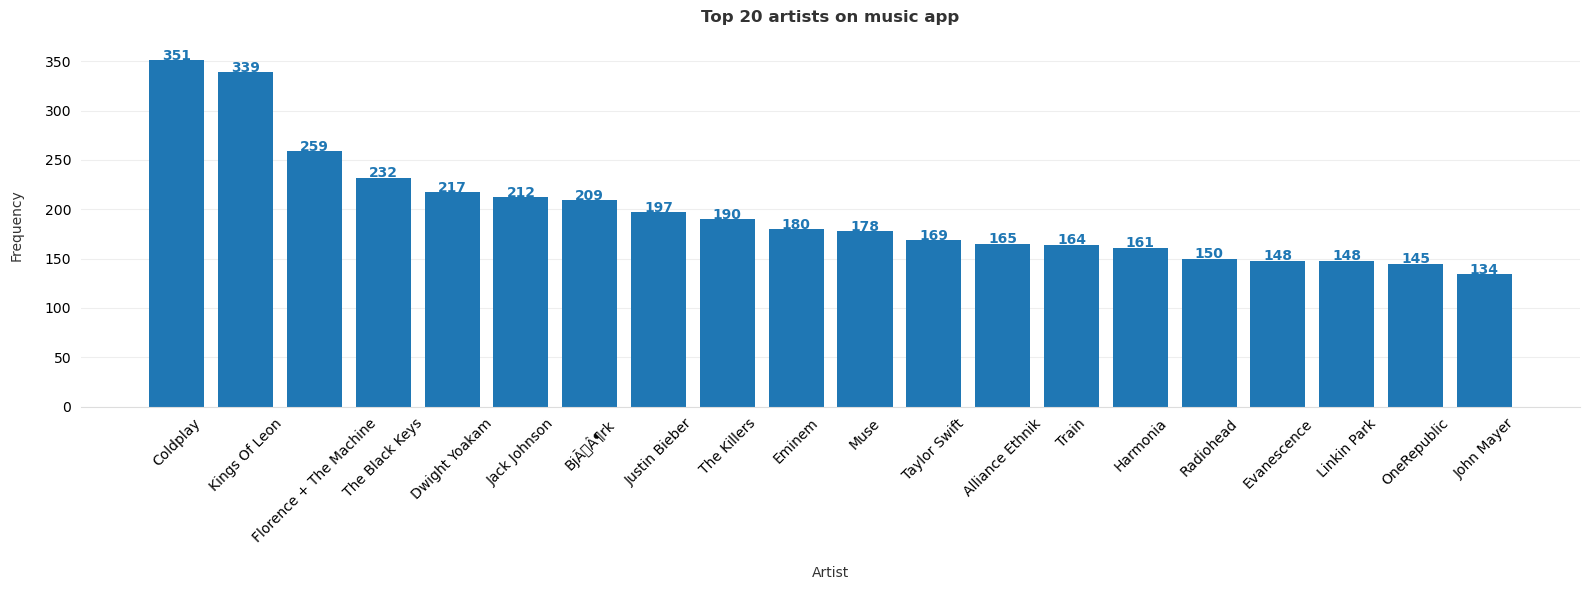

In [17]:
histogram_top_artist(data_clean, 20)

In [18]:
def create_churn(df, PageChurnString):
    '''
    Create churn column about DataFrame 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        df_churn - df updated with churn rate column 
    '''
    # print(type(df.columns))
    if "churnedEvent" in df.columns:
        flag_downgrade_event = udf(lambda x: 1 if x == PageChurnString else 0, IntegerType())
        df_churn = df.withColumn("churnedEvent", when(col("churnedEvent") == 1, 1).otherwise(flag_downgrade_event("page")))
    else:
        flag_downgrade_event = udf(lambda x: 1 if x == PageChurnString else 0, IntegerType())
        df_churn = df.withColumn("churnedEvent", flag_downgrade_event("page"))

    distinct_churned_users = df_churn.filter(df_churn.churnedEvent == 1).select('userId').distinct()
    list_distinct_churned_users = list(distinct_churned_users.select('userId').toPandas()['userId'])

    df_churn = df_churn.withColumn('churnedUser', when(df_churn.userId.isin(list_distinct_churned_users), 1).otherwise(0)) 

    return df_churn


In [19]:
# Preliminary analysis
unique_per_column, unique_for_page_column = describe_data_prelim_analysis(data_clean) 

DataFrame shape: 	rows=52853, 	columns=9

Unique values per column:
+------+------+------+-----+--------+----+-----+-----+------+
|artist|gender|length|level|location|page| song|   ts|userId|
+------+------+------+-----+--------+----+-----+-----+------+
|  9088|     2|  9741|    2|      87|  19|21479|51671|   133|
+------+------+------+-----+--------+----+-----+-----+------+


Unique page actions:
+-------------------------+-----------+
|page                     |count(page)|
+-------------------------+-----------+
|Cancel                   |9          |
|Submit Downgrade         |17         |
|Thumbs Down              |421        |
|Home                     |2061       |
|Downgrade                |358        |
|Roll Advert              |1004       |
|Logout                   |642        |
|Save Settings            |60         |
|Cancellation Confirmation|9          |
|About                    |76         |
|Settings                 |293        |
|Add to Playlist          |1244       |

In [20]:
unique_per_column[0]

Row(artist=9088, gender=2, length=9741, level=2, location=87, page=19, song=21479, ts=51671, userId=133)

In [21]:
# get values for plotting unique values per column
unique_values_per_column_list = []
for item in unique_per_column[0]: 
    unique_values_per_column_list.append(item)
    # print(item)

#Get All column names
column_names_list = []
for field in data_clean.schema.fields:
    column_names_list.append(field.name)
    # print(field.name)

In [22]:
def number_of_unique_values(colNames_list, colValues_list, figsize=(12, 4), rotation=False, log_yaxis=False):
    '''
    Plot number of unique values 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Plot
    '''

    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle('Number of unique values in each column of a DataFrame')

    bars = ax.bar(x = np.array(colNames_list), height=np.array(colValues_list), log=log_yaxis)
    ax.bar_label(bars, label_type='edge')
    ax.set_xlabel('Column name')
    ax.set_ylabel('Frequency')
    plt.xticks(rotation = 45) if rotation else None

    # ax.set_ylim(None, max(churned, active) * 1.5)

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


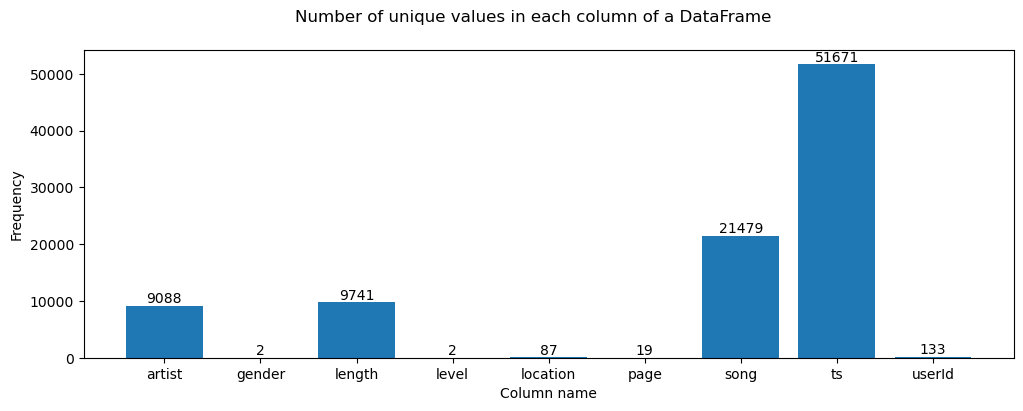

In [23]:
number_of_unique_values(column_names_list, unique_values_per_column_list)

In [24]:
# For Page column - get values for plotting unique values per event and get All event names
unique_values_per_page_column_list = []
column_page_names_list = []
for item in unique_for_page_column: 
    unique_values_per_page_column_list.append(item[1])
    column_page_names_list.append(item[0])
    # print(item)
print(unique_values_per_page_column_list)
print(column_page_names_list)

[9, 17, 421, 2061, 358, 1004, 642, 60, 9, 76, 293, 1244, 784, 43189, 2151, 290, 145, 58, 42]
['Cancel', 'Submit Downgrade', 'Thumbs Down', 'Home', 'Downgrade', 'Roll Advert', 'Logout', 'Save Settings', 'Cancellation Confirmation', 'About', 'Settings', 'Add to Playlist', 'Add Friend', 'NextSong', 'Thumbs Up', 'Help', 'Upgrade', 'Error', 'Submit Upgrade']


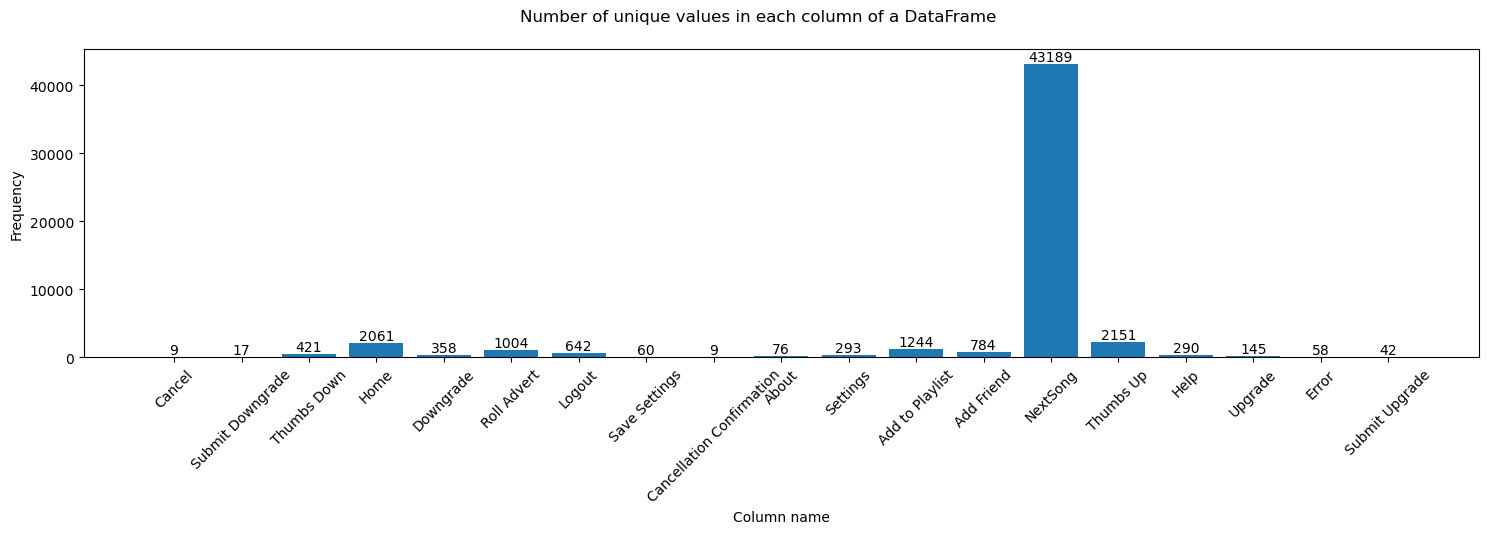

In [25]:
number_of_unique_values(column_page_names_list, unique_values_per_page_column_list, (18,4), True)

In [26]:
# Define churn
data_churn = create_churn(data_clean, 'Cancellation Confirmation')
# data_churn = create_churn(data_churn, 'Submit Downgrade')
# data_churn = create_churn(data_churn, 'Downgrade')
del data_clean

In [27]:
data_churn.show()

+--------------------+------+---------+-----+--------------------+---------------+--------------------+-------------+------+------------+-----------+
|              artist|gender|   length|level|            location|           page|                song|           ts|userId|churnedEvent|churnedUser|
+--------------------+------+---------+-----+--------------------+---------------+--------------------+-------------+------+------------+-----------+
|      Martha Tilston|     M|277.89016| paid|     Bakersfield, CA|       NextSong|           Rockpools|1538352117000|    30|           0|          0|
|    Five Iron Frenzy|     M|236.09424| free|Boston-Cambridge-...|       NextSong|              Canada|1538352180000|     9|           0|          0|
|        Adam Lambert|     M| 282.8273| paid|     Bakersfield, CA|       NextSong|   Time For Miracles|1538352394000|    30|           0|          0|
|              Enigma|     M|262.71302| free|Boston-Cambridge-...|       NextSong|Knocking On Forbi.

In [28]:
print(f"Number of unique users in dataset = {data_churn.select('userId').distinct().count()}")
print(f"Number of actions in dataset = {data_churn.count()}")
print(f"Number of churned users = {data_churn.filter(data_churn.churnedUser == 1).select('userId').distinct().count()}")
print(f"Number of active users = {data_churn.filter(data_churn.churnedUser == 0).select('userId').distinct().count()}")
print(f"Number of actions associated with churned users = {data_churn.filter(data_churn.churnedUser == 1).count()}")
print(f"Number of actions associated with active users = {data_churn.filter(data_churn.churnedUser == 0).count()}")

Number of unique users in dataset = 133
Number of actions in dataset = 52853
Number of churned users = 9
Number of active users = 124
Number of actions associated with churned users = 6278
Number of actions associated with active users = 46575


In [29]:
print(f'Print example DataFrames with churn column where Page == x:\n')
print(f'Top df row: ')
data_churn.show(1)
print(f'Page == Submit Downgrade: ')
data_churn.filter(data_churn.page == "Submit Downgrade").show(1)
print(f'Page == Downgrade: ')
data_churn.filter(data_churn.page == "Downgrade").show(1)
print(f'Page == Cancellation Confirmation: ')
data_churn.filter(data_churn.page == "Cancellation Confirmation").show(1)

Print example DataFrames with churn column where Page == x:

Top df row: 
+--------------+------+---------+-----+---------------+--------+---------+-------------+------+------------+-----------+
|        artist|gender|   length|level|       location|    page|     song|           ts|userId|churnedEvent|churnedUser|
+--------------+------+---------+-----+---------------+--------+---------+-------------+------+------------+-----------+
|Martha Tilston|     M|277.89016| paid|Bakersfield, CA|NextSong|Rockpools|1538352117000|    30|           0|          0|
+--------------+------+---------+-----+---------------+--------+---------+-------------+------+------------+-----------+
only showing top 1 row

Page == Submit Downgrade: 
+------+------+------+-----+--------------------+----------------+----+-------------+------+------------+-----------+
|artist|gender|length|level|            location|            page|song|           ts|userId|churnedEvent|churnedUser|
+------+------+------+-----+------

Observe the behavior for active users vs users who churned. 
- You can start by exploring aggregates on these two groups of users" , " observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [30]:
data_churn.show(3)

+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+
|          artist|gender|   length|level|            location|    page|             song|           ts|userId|churnedEvent|churnedUser|
+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+
|  Martha Tilston|     M|277.89016| paid|     Bakersfield, CA|NextSong|        Rockpools|1538352117000|    30|           0|          0|
|Five Iron Frenzy|     M|236.09424| free|Boston-Cambridge-...|NextSong|           Canada|1538352180000|     9|           0|          0|
|    Adam Lambert|     M| 282.8273| paid|     Bakersfield, CA|NextSong|Time For Miracles|1538352394000|    30|           0|          0|
+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+
only showing top 3 rows



In [31]:
def categorical_and_numeric_columns(df):
    '''
    Create list of categorical & numerical columns 
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        categories_list - list of categorical data
        numerical_list - list of numerical data
    '''


    categories_list = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
    numerical_list = [f.name for f in df.schema.fields if not isinstance(f.dataType, StringType)]

    # manual updates
    # categories_list.append('status')
    categories_list.remove('location')
    categories_list.remove('artist')
    categories_list.remove('song')
    # categories_list.remove('userAgent')
    categories_list.remove('page')

    print("Categorical data: ", categories_list)
    print("Numerical data: ", numerical_list)
    return categories_list, numerical_list

def number_of_churned_users(df, log_yaxis=False):
    '''
    Plot number of churned vs active users
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Plot
    '''

    fig, ax = plt.subplots(figsize=(4, 4))
    fig.suptitle('Number of churned vs active users')

    churned = df.filter(df.churnedUser == 1).select('userId').distinct().count()
    active = df.filter(df.churnedUser == 0).select('userId').distinct().count()
    bars = ax.bar(x = np.array(['churned', 'active']), height=np.array([churned, active]), log=log_yaxis)
    ax.bar_label(bars, label_type='edge')
    ax.set_ylim(None, max(churned, active) * 1.5)

def number_of_churned_user_actions(df, log_yaxis=False):
    '''
    Plot number of actions associated with churned vs active users
    INPUT
        df - spark or pandas DataFrame
    OUTPUT
        Plot
    '''

    fig, ax = plt.subplots(figsize=(4, 4))
    fig.suptitle('Number of actionas associated with churned vs active users')

    churned = df.filter(df.churnedUser == 1).count()
    active = df.filter(df.churnedUser == 0).count()
    bars = ax.bar(x = np.array(['churned', 'active']), height=np.array([churned, active]), log=log_yaxis)
    ax.bar_label(bars, label_type='edge')
    ax.set_ylim(None, max(churned, active) * 1.5)


def create_churned_and_active_lists(cat, pd_value_counts_data, status_unique):
    '''
    Create list of churned and active usercounts from value_counts DataFrame and a specific category. 
    Set count to 0 if no counts available.
    INPUT
        cat - category to define churned vs active counts (ex. "auth")
        pd_value_counts_data - spark or pandas DataFrame grouped by value_counts function
        ex. pd_value_counts_data = 
                    auth  churned  count
                0  Cancelled        1      9
                1  Logged In        1    375
                2  Logged In        0  52469
        status_unique - list of unique values from category column (ex. ['Cancelled', 'Logged In'])
    OUTPUT
        churned_count_list - list of churned user counts for each status_unique value 
        active_count_list - list of active user counts for each status_unique value
    '''

    churned_count_list = []
    active_count_list = []
    for s in status_unique:

        churn_vals = pd_value_counts_data[
            (pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 1)
            ]['count'].values[0] if len(
                pd_value_counts_data[(pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 1)]['count']
                ) > 0 else 0

        stay_vals = pd_value_counts_data[
            (pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 0)
            ]['count'].values[0] if len(
                pd_value_counts_data[(pd_value_counts_data[cat] == s) & (pd_value_counts_data['churnedUser'] == 0)]['count']
                ) > 0 else 0

        churn_vals_count = churn_vals
        stay_vals_count = stay_vals

        if (churn_vals_count == 0) & (stay_vals_count == 0):
            churned_count_list.append(0)
            active_count_list.append(0)

        elif (churn_vals_count == 0) & (stay_vals_count > 0):
            churned_count_list.append(0)
            active_count_list.append(stay_vals)

        elif (churn_vals_count > 0) & (stay_vals_count == 0):
            active_count_list.append(0)
            churned_count_list.append(churn_vals)

        else:
            churned_count_list.append(churn_vals)
            active_count_list.append(stay_vals)

    return churned_count_list, active_count_list

def categorical_data_churn_rate_plots(df, categories):
    '''
    Plot churned vs active user bar plots for each category in list of categorical data columns.
    INPUT
        categories - list of categorical data columns 
        df - spark or pandas DataFrame of all data
    OUTPUT
        Multiple plots
    '''

    fig, axes = plt.subplots(len(categories), figsize=(16, 12))
    fig.suptitle('Categorical data')

    i_idx = 0
    j_idx = 0

    for cat in categories: 

        value_counts_data = value_counts(data_churn, [cat, 'churnedUser'])
        value_counts_data.show()
        pd_value_counts_data = value_counts_data.toPandas()
        cat_unique = value_counts_data.select(cat).distinct().toPandas()[cat].to_list()
        print(cat_unique)
        print(cat)
        print(pd_value_counts_data)

        churned_count_list, active_count_list = create_churned_and_active_lists(cat, pd_value_counts_data, cat_unique)

        # set width of bar
        barWidth = 0.25

        x_arr = cat_unique
        y_arr = churned_count_list

        # Set position of bar on X axis
        x_arr1 = np.arange(len(pd_value_counts_data[cat].unique()))

        axes[j_idx].bar(x = x_arr1, height = y_arr, color='red', log=True, width = barWidth, label ='Churned')
        axes[j_idx].set_title(cat)

        y_arr = active_count_list
        x_arr2 = [x + barWidth for x in x_arr1]
        axes[j_idx].bar(x = x_arr2, height = y_arr, color='green', log=True, width = barWidth, label ='Active')

        # Adding Xticks
        axes[j_idx].set_xlabel(cat, fontweight ='bold', fontsize = 15)
        axes[j_idx].set_ylabel('Frequency', fontweight ='bold', fontsize = 15)
        axes[j_idx].set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 60, fontsize=12)
        
        j_idx += 1
        if j_idx > 2:
            j_idx = 0
            i_idx += 1
            
    fig.tight_layout()

def singleCategory_data_churn_rate_plot(df, category):
    '''
    Plot churned vs active users bar plot for a single category in list of categorical data columns.
    INPUT
        category - a categorical data column 
        df - spark or pandas DataFrame of all data
    OUTPUT
        Single plot
    '''

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle('Categorical data - number of actions for associated churned vs active user')

    value_counts_data = value_counts(data_churn, [category, 'churnedUser'])
    # value_counts_data.show()
    pd_value_counts_data = value_counts_data.toPandas()
    cat_unique = value_counts_data.select(category).distinct().toPandas()[category].to_list()

    churned_count_list, active_count_list = create_churned_and_active_lists(category, pd_value_counts_data, cat_unique)

    # set width of bar
    barWidth = 0.25
    # fig = plt.subplots(figsize =(6, 6))

    x_arr = cat_unique
    y_arr = churned_count_list

    # Set position of bar on X axis
    x_arr1 = np.arange(len(pd_value_counts_data[category].unique()))
    axes.bar(x = x_arr1, height = y_arr, color='red', log=True, width = barWidth, label ='Churned')
    axes.set_title(category)

    y_arr = active_count_list
    x_arr2 = [x + barWidth for x in x_arr1]
    axes.bar(x = x_arr2, height = y_arr, color='green', log=True, width = barWidth, label ='Active')

    # Adding Xticks
    axes.set_xlabel(category, fontweight ='bold', fontsize = 15)
    axes.set_ylabel('Frequency', fontweight ='bold', fontsize = 15)
    axes.set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 80, fontsize=12)
    axes.legend()

def singleCategory_data_churn_rate_plot_normalize(df, category, log_yaxis=False):
    '''
    Plot churned vs active users bar plot for a single category in list of categorical data columns.
    INPUT
        category - a categorical data column 
        df - spark or pandas DataFrame of all data
    OUTPUT
        Single plot
    '''

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle('Page data - % of actions vs total churned or active user actions')

    value_counts_data = value_counts(df, [category, 'churnedUser'])
    count_churnedActions = df.filter(df.churnedUser == 1).count()
    count_activeActions = df.filter(df.churnedUser == 0).count()

    value_counts_data = value_counts_data.\
        withColumn('count', when(col("churnedUser") == 1, col("count") / count_churnedActions).otherwise(col("count") / count_activeActions))#.\

    pd_value_counts_data = value_counts_data.toPandas()
    cat_unique = value_counts_data.select(category).distinct().toPandas()[category].to_list()

    churned_count_list, active_count_list = create_churned_and_active_lists(category, pd_value_counts_data, cat_unique)

    # set width of bar
    barWidth = 0.25

    x_arr = cat_unique
    y_arr = churned_count_list

    # Set position of bar on X axis
    x_arr1 = np.arange(len(pd_value_counts_data[category].unique()))
    axes.bar(x = x_arr1, height = y_arr, color='red', log=log_yaxis, width = barWidth, label ='Churned')
    axes.set_title(category)

    y_arr = active_count_list
    x_arr2 = [x + barWidth for x in x_arr1]
    axes.bar(x = x_arr2, height = y_arr, color='green', log=log_yaxis, width = barWidth, label ='active')

    # Adding Xticks
    axes.set_xlabel(category, fontweight ='bold', fontsize = 15)
    axes.set_ylabel('% of all churned or active actions', fontweight ='bold', fontsize = 15)
    axes.set_xticks([r + barWidth/2 for r in range(len(x_arr1))], cat_unique, rotation = 80, fontsize=12)
    axes.legend()

In [32]:
data_churn.describe().show()

+-------+------------------+------+------------------+-----+--------------------+-------+--------------------+--------------------+------------------+--------------------+-------------------+
|summary|            artist|gender|            length|level|            location|   page|                song|                  ts|            userId|        churnedEvent|        churnedUser|
+-------+------------------+------+------------------+-----+--------------------+-------+--------------------+--------------------+------------------+--------------------+-------------------+
|  count|             43189| 52853|             43189|52853|               52853|  52853|               43189|               52853|             52853|               52853|              52853|
|   mean| 653.8913043478261|  null|249.39433416842374| null|                null|   null|            Infinity|1.539090448714358...| 74.37057499101282|1.702836168240213...|0.11878228293568956|
| stddev|1777.0026852760411|  null|100.3

In [33]:
cat_col_list, num_col_list = categorical_and_numeric_columns(data_churn)

Categorical data:  ['gender', 'level']
Numerical data:  ['length', 'ts', 'userId', 'churnedEvent', 'churnedUser']


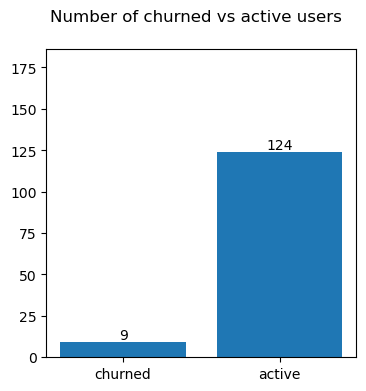

In [34]:
number_of_churned_users(data_churn)

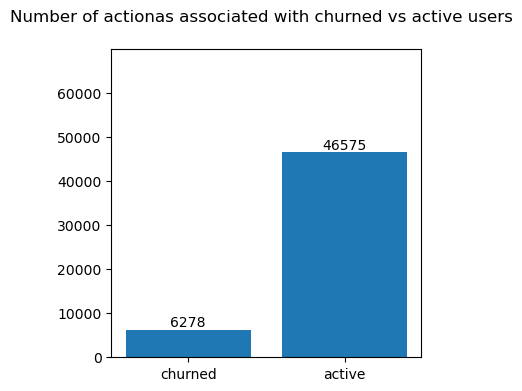

In [35]:
number_of_churned_user_actions(data_churn)

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


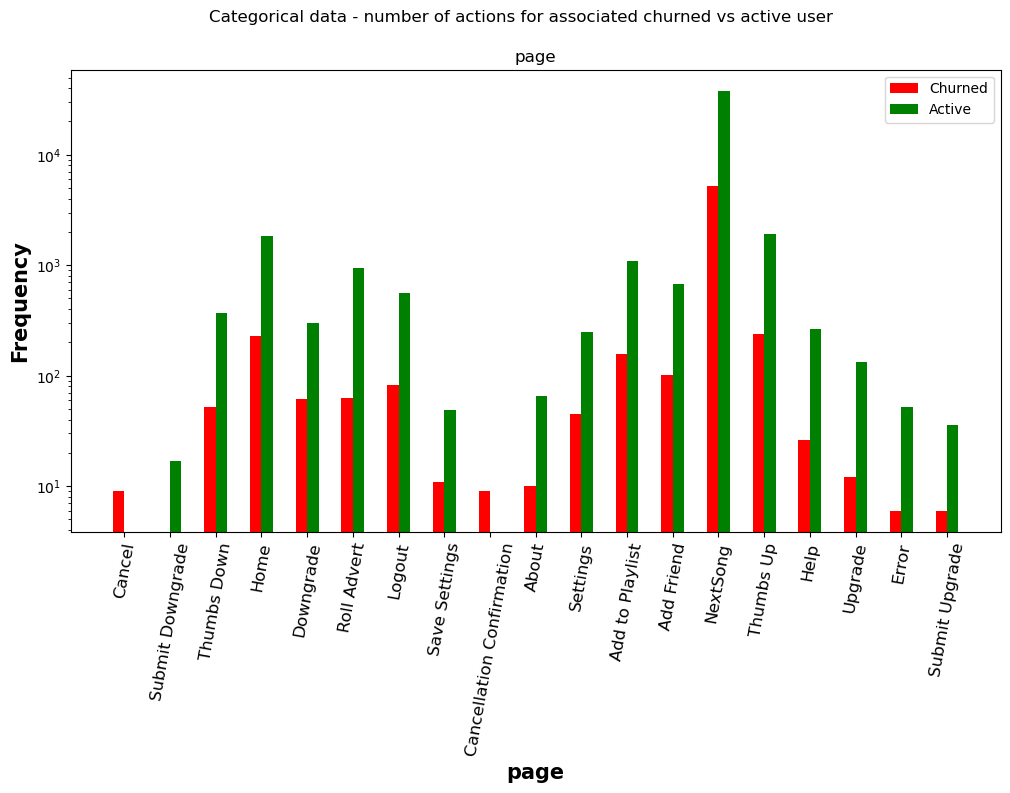

In [36]:
singleCategory_data_churn_rate_plot(data_churn, 'page')

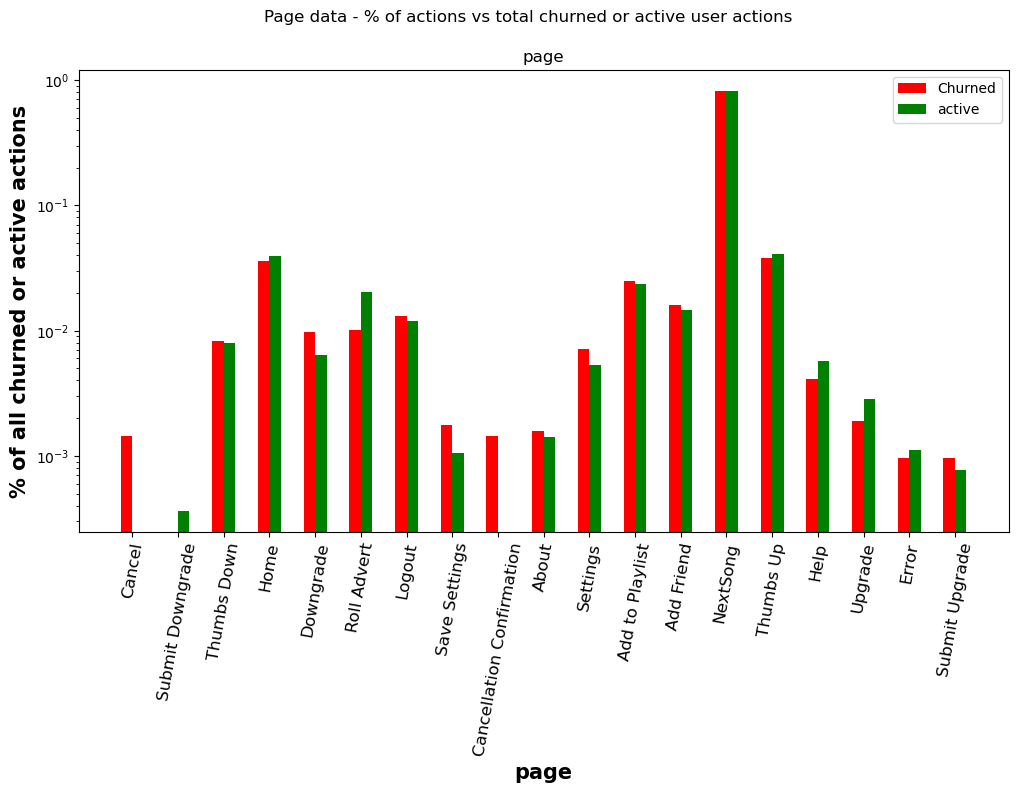

In [37]:
log_yaxis=True
singleCategory_data_churn_rate_plot_normalize(data_churn, 'page', log_yaxis)

In [38]:
print(f'Categories to investigate = {cat_col_list}')

Categories to investigate = ['gender', 'level']


+------+-----------+-----+
|gender|churnedUser|count|
+------+-----------+-----+
|     F|          1| 1251|
|     M|          1| 5027|
|     M|          0|20232|
|     F|          0|26343|
+------+-----------+-----+

['F', 'M']
gender
  gender  churnedUser  count
0      F            1   1251
1      M            1   5027
2      M            0  20232
3      F            0  26343
+-----+-----------+-----+
|level|churnedUser|count|
+-----+-----------+-----+
| free|          1|  751|
| paid|          1| 5527|
| free|          0|15786|
| paid|          0|30789|
+-----+-----------+-----+

['free', 'paid']
level
  level  churnedUser  count
0  free            1    751
1  paid            1   5527
2  free            0  15786
3  paid            0  30789


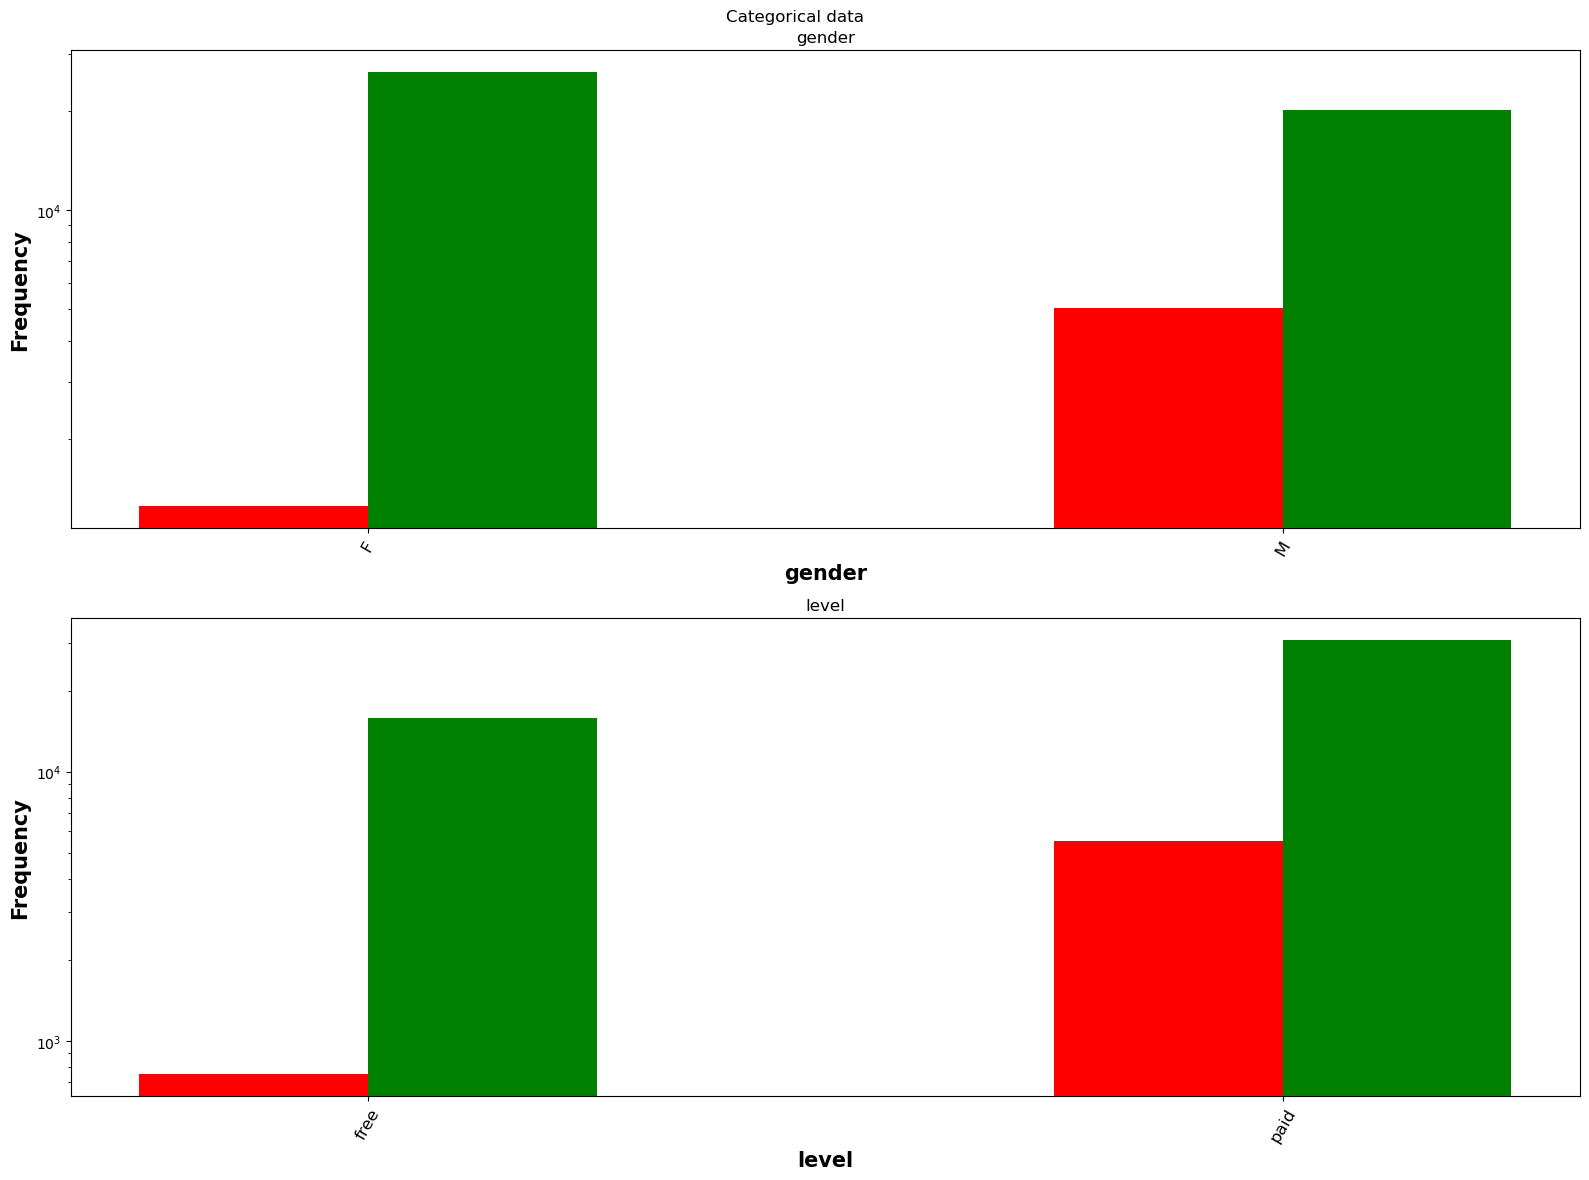

In [39]:
categorical_data_churn_rate_plots(data_churn, cat_col_list)

### You can start by exploring aggregates on these two groups of users" , " observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [40]:
def count_songs_in_hour(df):
    '''
    Count number of songs / rows for a specific hour of the day
    INPUT
        df - spark or pandas DataFrame of all data
    OUTPUT
        df - spark or pandas DataFrame with hour column added
        songs_in_hour - count of songs/rows for a specific hour of the day
    '''
    get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000).hour)
    df = df.withColumn("hour", get_hour(df.ts))
    songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))
    return df, songs_in_hour

def create_date_column(df):
    '''
    Convert (ts) timestamp column to datetime & date columns 
    INPUT
        df - spark or pandas DataFrame of all data
    OUTPUT
        df - spark or pandas DataFrame with datetime & date column added
    '''
    get_datetime = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000), TimestampType())
    new_df = df.withColumn("date_time", get_datetime(df.ts))
    
    print(f"Min datetime = \t{new_df.agg({'date_time': 'min'}).collect()[0]}")
    print(f"Max datetime = \t{new_df.agg({'date_time': 'max'}).collect()[0]}")

    # df.withColumn("ts", to_timestamp(col("input_timestamp"))).withColumn("datetype",to_date(col("ts")))
    new_df = new_df.withColumn("date", to_date(col("date_time")))

    return new_df

def plot_number_of_songs_in_each_day_hour(songs_in_hour, usersNames):
    '''
    Plot number of songs played in each day hour
    INPUT
        songs_in_hour - hour & number of songs count table
    OUTPUT
        Single plot
    '''
    songs_in_hour_pd = songs_in_hour.toPandas()
    songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Songs per hour - UID = {usersNames}')

    axes.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
    axes.set_xlim(-1, 24)
    axes.set_ylim(0, 1.2 * max(songs_in_hour_pd["count"]))
    axes.set_xlabel("Hour")
    axes.set_ylabel("Songs played")

def plot_number_of_songs_in_each_day_hour_churned_vs_active(songs_in_hour_for_churned, songs_in_hour_for_active, usersNames):
    '''
    Plot number of songs played in each day hour
    INPUT
        songs_in_hour - hour & number of songs count table
    OUTPUT
        Single plot
    '''

    fig, axes = plt.subplots(figsize=(12, 6))
    fig.suptitle(f'Songs per hour - UID = {usersNames}')

    songs_in_hour_churned_pd = songs_in_hour_for_churned.toPandas()
    songs_in_hour_churned_pd.hour = pd.to_numeric(songs_in_hour_churned_pd.hour)
    axes.scatter(songs_in_hour_churned_pd["hour"], songs_in_hour_churned_pd["count"], label='churned')

    songs_in_hour_active_pd = songs_in_hour_for_active.toPandas()
    songs_in_hour_active_pd.hour = pd.to_numeric(songs_in_hour_active_pd.hour)
    axes.scatter(songs_in_hour_active_pd["hour"], songs_in_hour_active_pd["count"], label='active')
    
    axes.set_xlim(-1, 24)
    axes.set_ylim(0, 1.2 * max(max(songs_in_hour_churned_pd["count"]), max(songs_in_hour_active_pd["count"])))
    axes.set_xlabel("Hour")
    axes.set_ylabel("Songs played")
    axes.legend()

def concert_timestamp_to_date_time(data_churn):
    '''
    Convert timestamp to date time (date + time)
    INPUT
        data_churn - spark or pandas DataFrame of all data
    OUTPUT
        new_data_churn - data_churn DataFrame + date_time column
    '''
    # Convert timestamp to date_time
    new_data_churn = create_date_column(data_churn)
    new_data_churn.select('date_time').show(1, truncate = False)
    new_data_churn.select('date').show(1, truncate = False)
    return new_data_churn

def create_cumulative_churn_event_plot(new_data_churn):
    '''
    Plot cumulative number of churned events at increasing datetime
    INPUT
        new_data_churn - spark or pandas DataFrame of all data
    OUTPUT
        Single plot
    '''
    
    df_w_cumsum = new_data_churn.alias('df_w_cumsum')

    windowval = (Window.partitionBy('churnedUser').orderBy('date_time').rangeBetween(Window.unboundedPreceding, 0))
    df_w_cumsum = df_w_cumsum.withColumn('cum_sum', Fsum('churnedEvent').over(windowval))

    plt.figure(figsize=(16, 6), dpi=80)
    plt.scatter(df_w_cumsum.filter(df_w_cumsum.churnedUser == 1).select('date_time').collect(), df_w_cumsum.filter(df_w_cumsum.churnedUser == 1).select('cum_sum').collect(), label='churned')
    plt.title('Churned events cumulative')
    plt.xlabel('Date')
    plt.ylabel('Frequency')
    plt.legend()


Min datetime = 	Row(min(date_time)=datetime.datetime(2018, 10, 1, 2, 1, 57))
Max datetime = 	Row(max(date_time)=datetime.datetime(2018, 10, 17, 9, 8, 36))
+-------------------+
|date_time          |
+-------------------+
|2018-10-01 02:01:57|
+-------------------+
only showing top 1 row

+----------+
|date      |
+----------+
|2018-10-01|
+----------+
only showing top 1 row



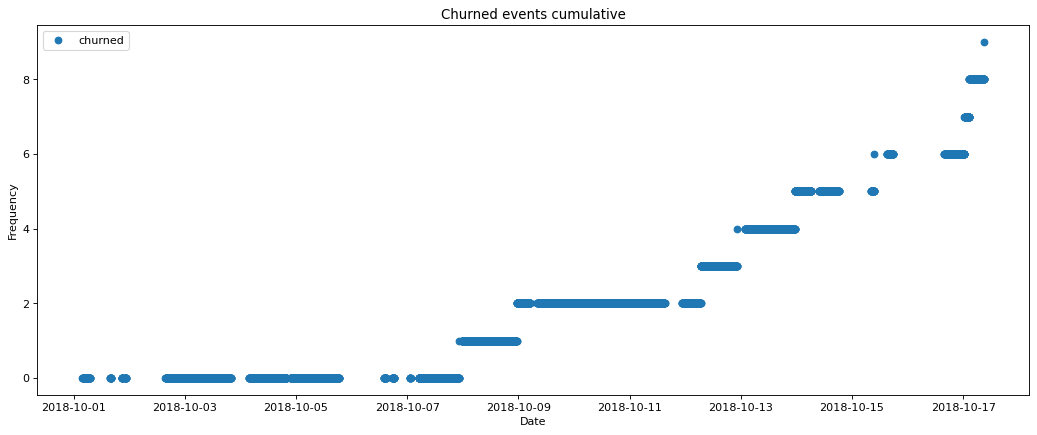

In [41]:
# Convert timestamp to date_time and create a cumulative churned event plot
new_data_churn = concert_timestamp_to_date_time(data_churn)
create_cumulative_churn_event_plot(new_data_churn)


In [42]:
def aggregate_per_day(new_data_churn, event):
    '''
    Aggregate the number of times an event occurs per day (for example: Page - Logout actions per day)
    INPUT
        event - event to be aggregated 
    OUTPUT
        events_perDay - grouped and counted pyspark DataFrame with columns "churnedUser" and "date"
    '''
    return new_data_churn.where(new_data_churn.page == event).groupby('churnedUser', 'date').count().sort('date')

def plot_churned_vs_active(events_perDay, event, new_data_churn, cumulativeChurn):
    '''
    Plot churned vs active users for specific events per day (for example: Page - Logout actions per day)
    INPUT
        events_perDay - spark or pandas DataFrame of all data
    OUTPUT
        Single plot
    '''

    fig, ax1 = plt.subplots(figsize=(16, 6), dpi=80)
    ax2 = ax1.twinx()

    if cumulativeChurn:
        df_w_cumsum = new_data_churn.alias('df_w_cumsum')

        windowval = (Window.partitionBy('churnedUser').orderBy('date_time').rangeBetween(Window.unboundedPreceding, 0))
        df_w_cumsum = df_w_cumsum.withColumn('cum_sum', Fsum('churnedEvent').over(windowval))

        ax2.plot(df_w_cumsum.filter(df_w_cumsum.churnedUser == 1).select('date_time').collect(), df_w_cumsum.filter(df_w_cumsum.churnedUser == 1).select('cum_sum').collect(), '--', linewidth=1, color='gray', label='CumulativeChurned')
    
    
    ax1.plot(events_perDay.filter(events_perDay.churnedUser == 1).select('date').collect(), events_perDay.filter(events_perDay.churnedUser == 1).select('count').collect(), label='churned')
    ax1.plot(events_perDay.filter(events_perDay.churnedUser == 0).select('date').collect(), events_perDay.filter(events_perDay.churnedUser == 0).select('count').collect(), label='active')
    ax1.set_title(f'Churned vs active users - {event} events per day')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Frequency (event)')
    ax1.legend(loc = 'upper left')
    ax2.set_ylabel('Cumulative churn events')
    ax2.legend(loc = 'upper right')

def number_of_events_per_day(new_data_churn, event, cumulativeChurn=False):
    '''
    Aggregate and plot the aggregated number of times an event occurs per day (for example: Page - Logout actions per day)
    INPUT
        new_data_churn - pyspark DataFrame with all data
        event - event to be aggregated 
    OUTPUT
        Single plot
    '''
    events_perDay = aggregate_per_day(new_data_churn, event)
    plot_churned_vs_active(events_perDay, event, new_data_churn, cumulativeChurn)   

In [43]:
# unique_page_events = list(new_data_churn.select(col('page')).distinct().collect())
removeEvents = {'Cancellation Confirmation', 'Downgrade', 'Submit Downgrade'}
unique_page_events = new_data_churn.rdd.map(lambda x: x.page).distinct().collect()
unique_page_events = [ele for ele in unique_page_events if ele not in removeEvents]
unique_page_events


['Thumbs Down',
 'Home',
 'Logout',
 'Help',
 'Settings',
 'About',
 'Error',
 'NextSong',
 'Add to Playlist',
 'Roll Advert',
 'Thumbs Up',
 'Upgrade',
 'Add Friend',
 'Submit Upgrade',
 'Save Settings',
 'Cancel']

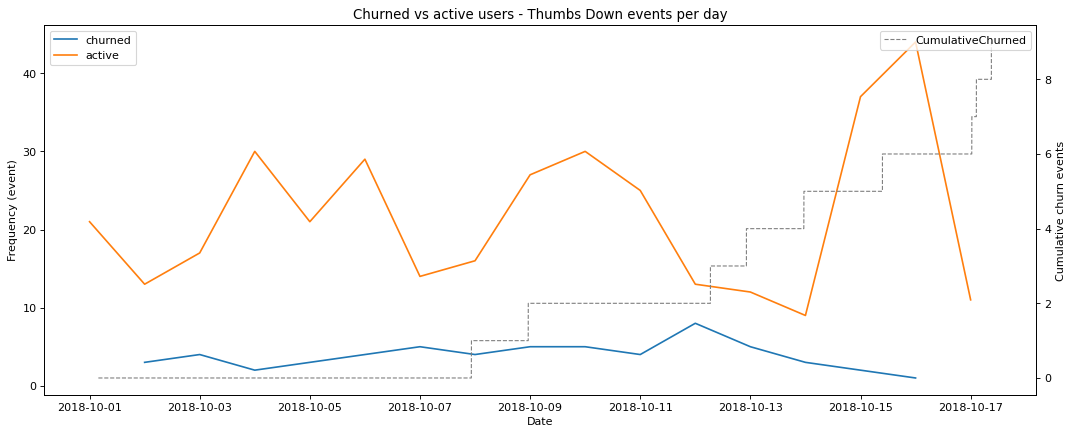

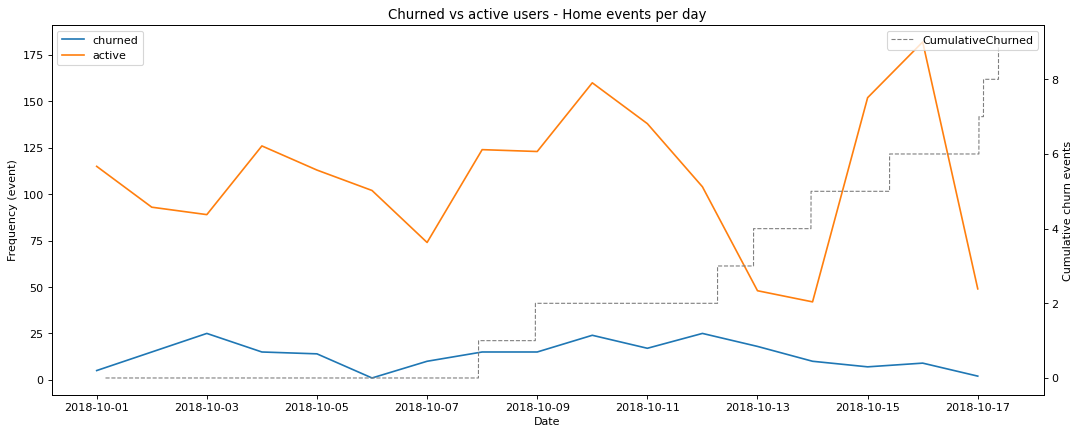

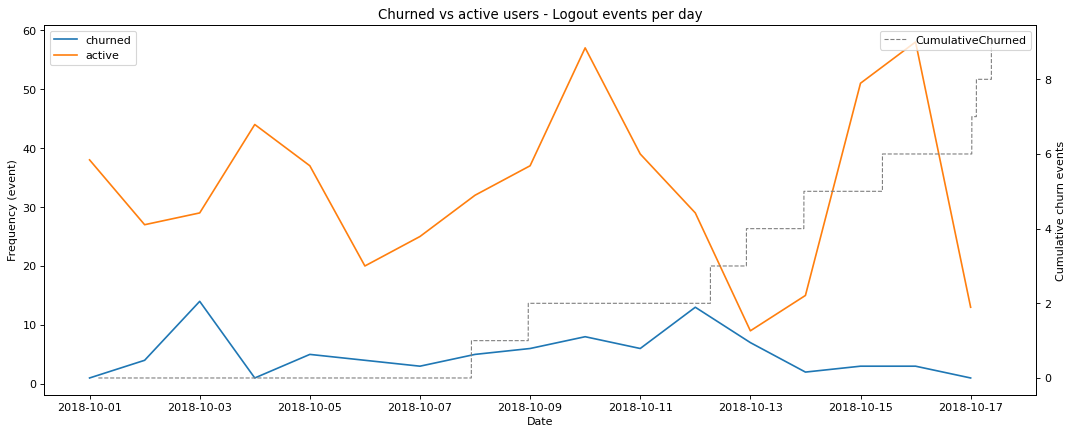

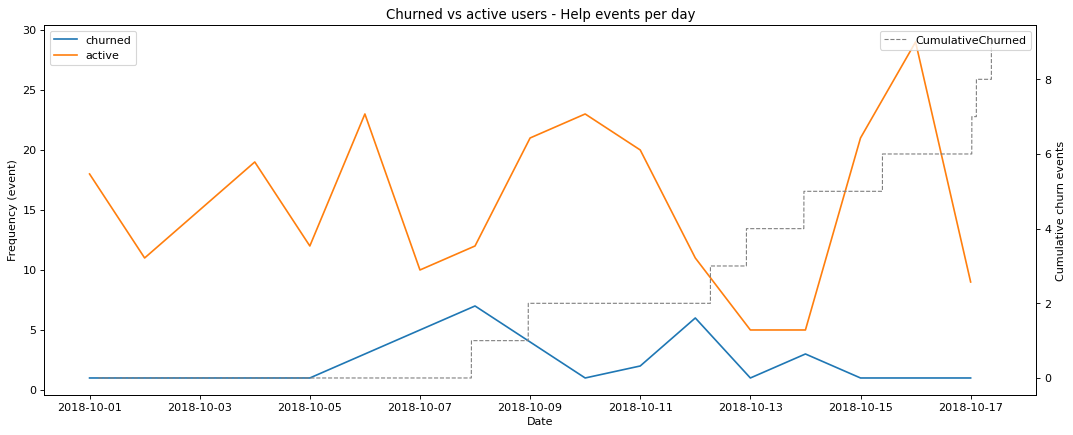

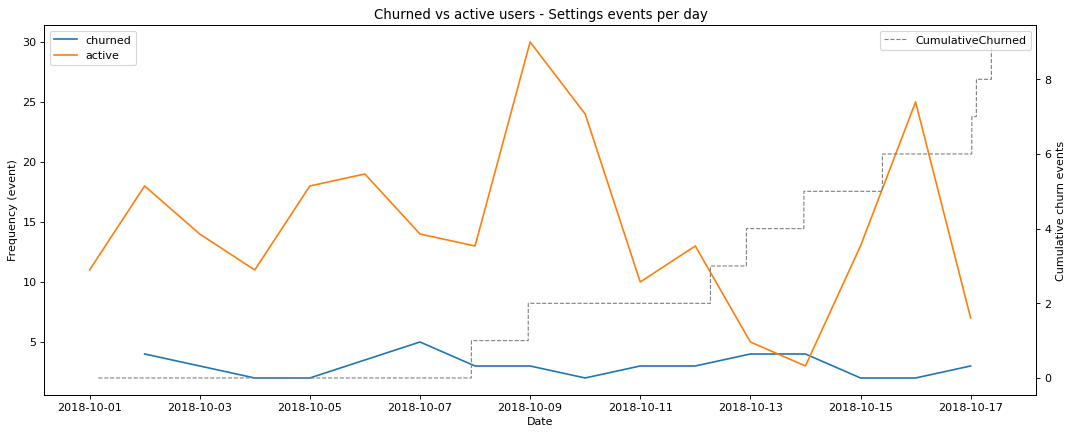

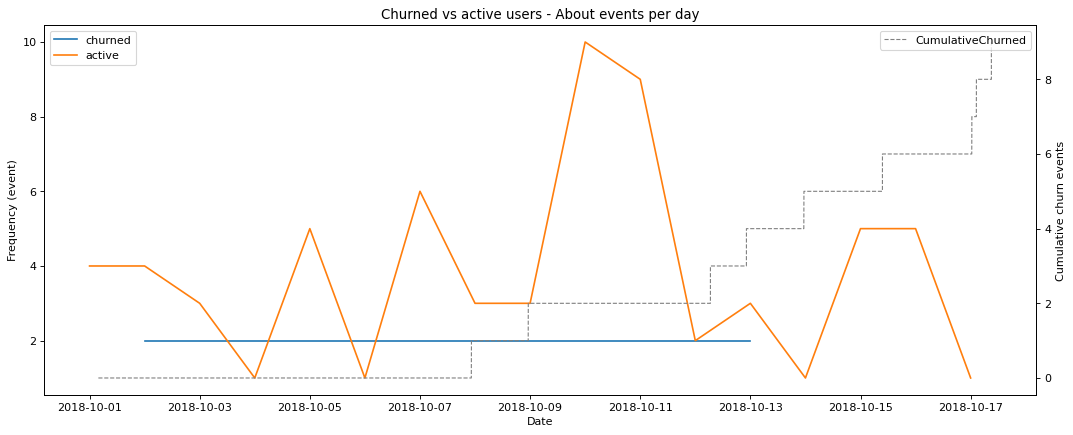

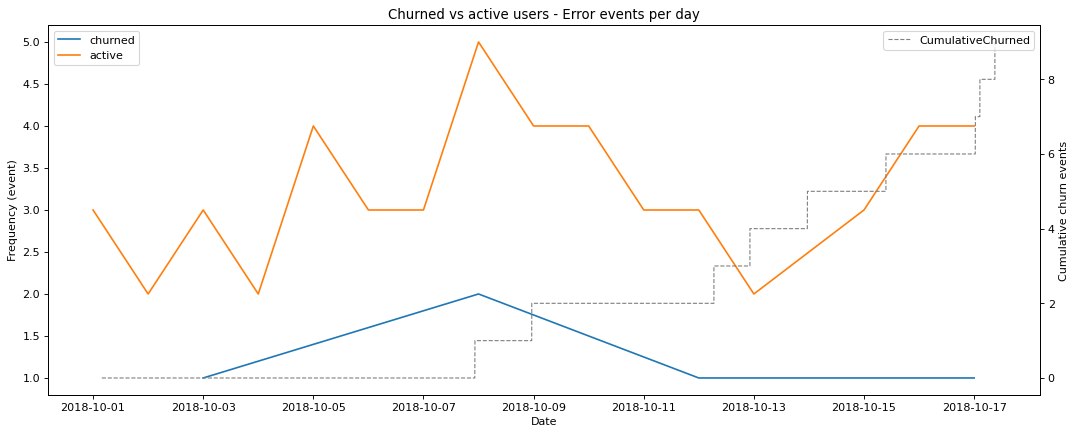

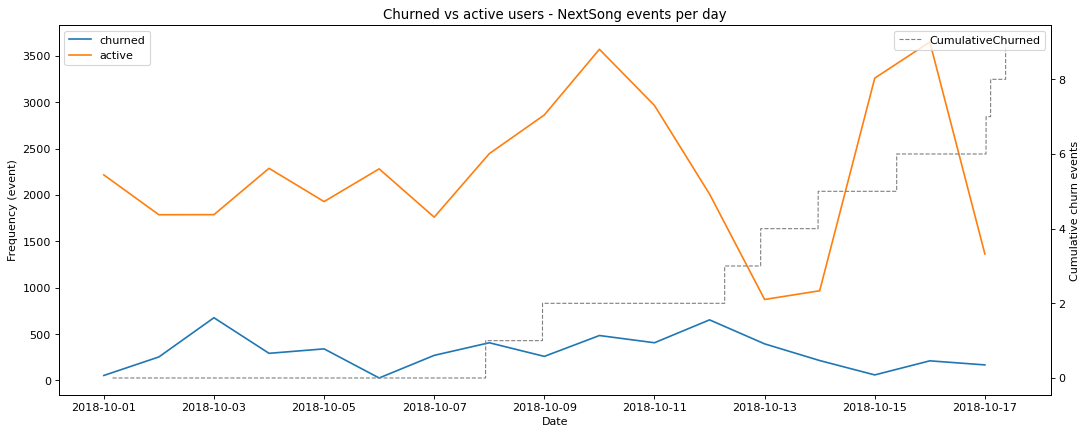

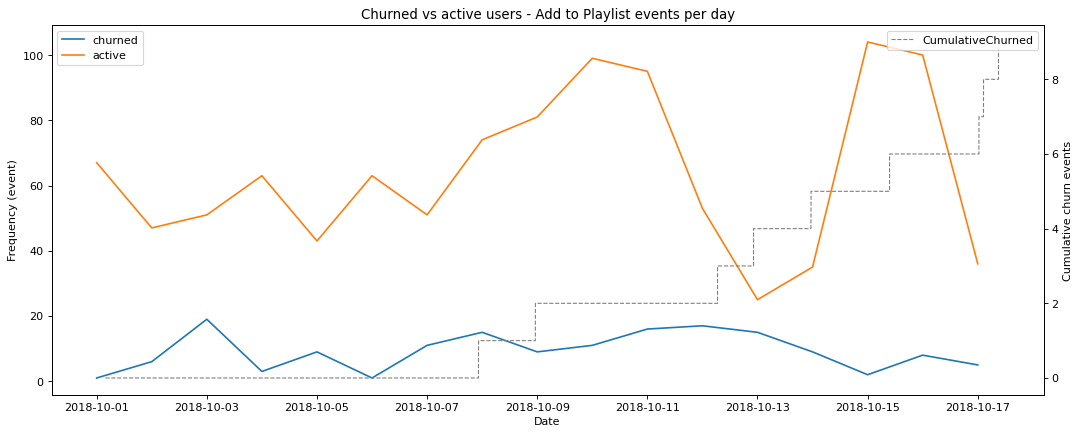

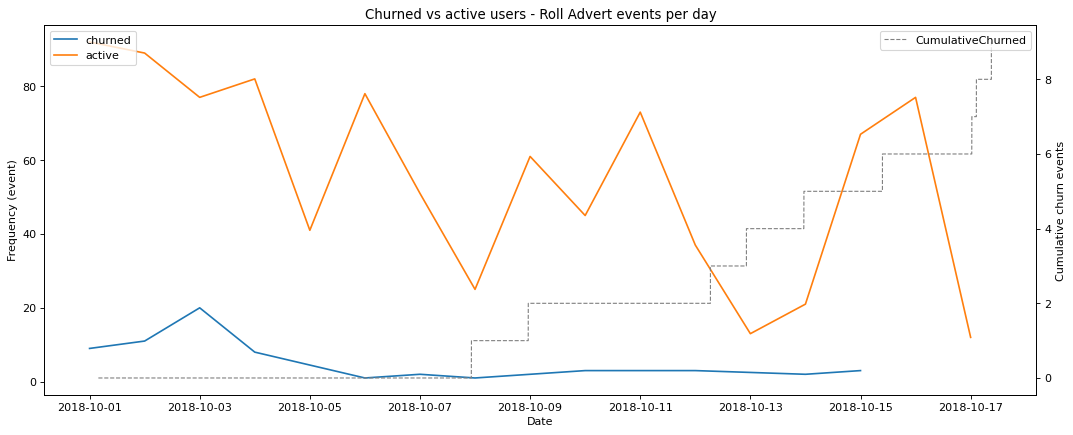

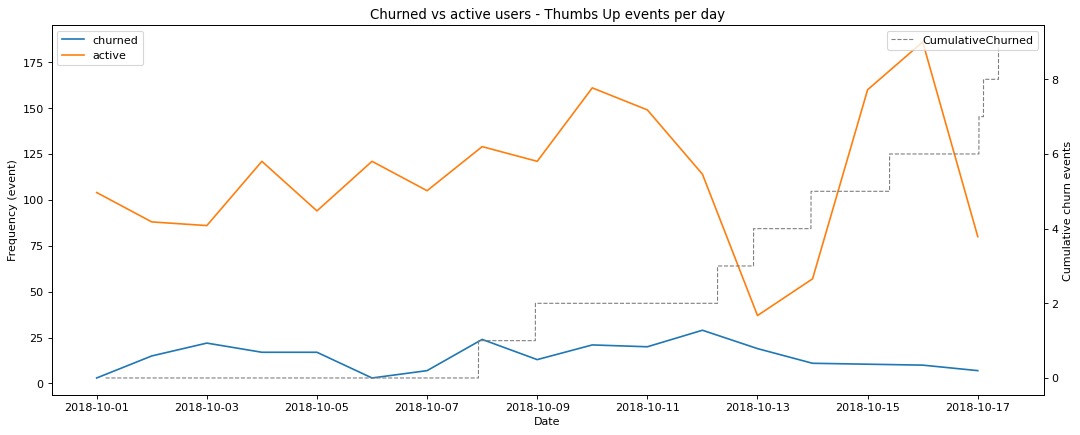

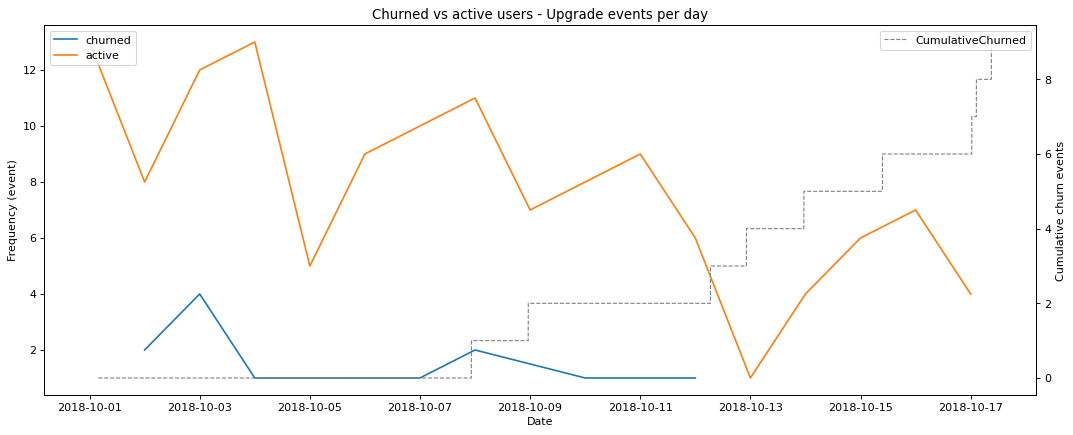

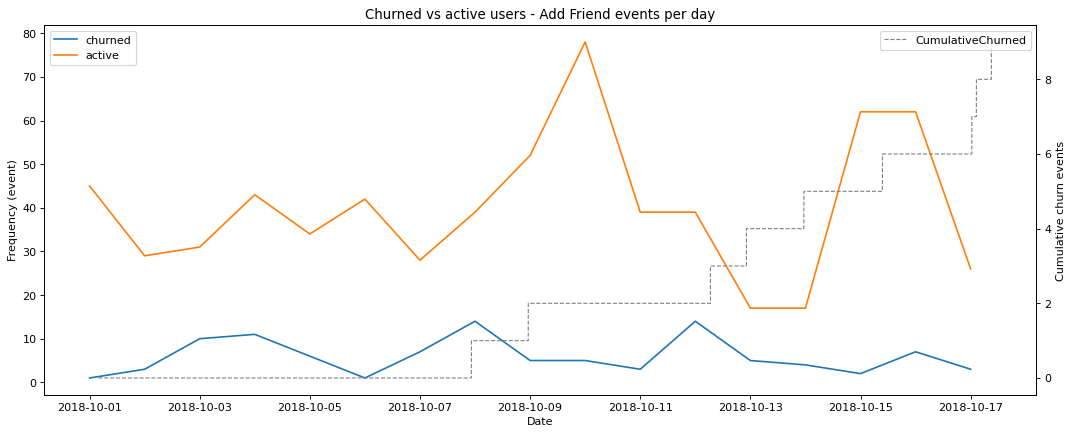

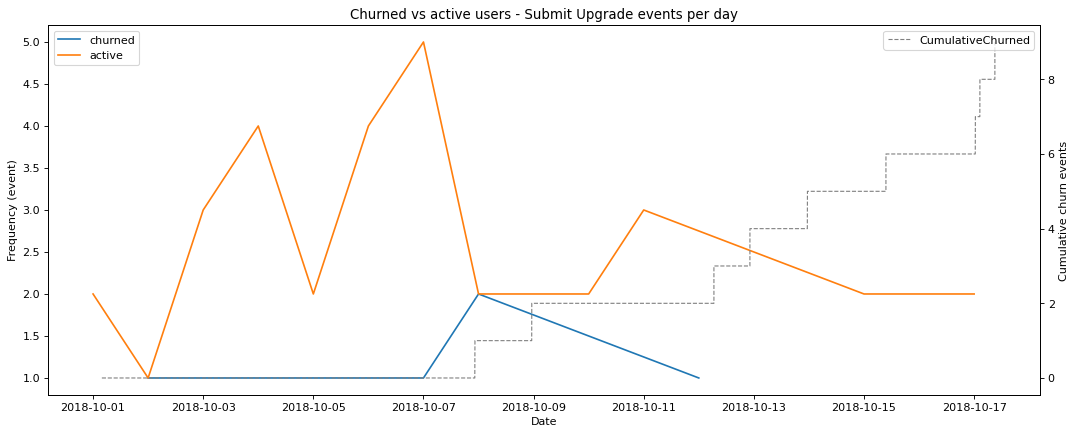

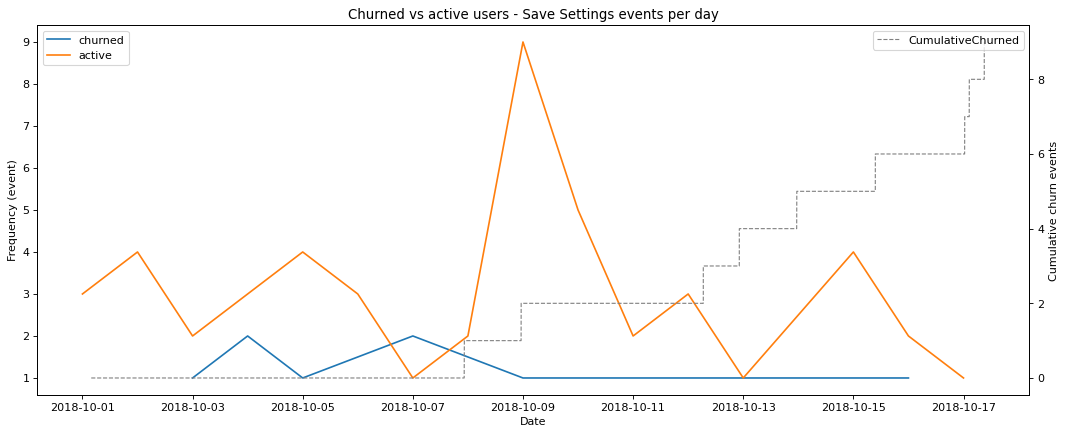

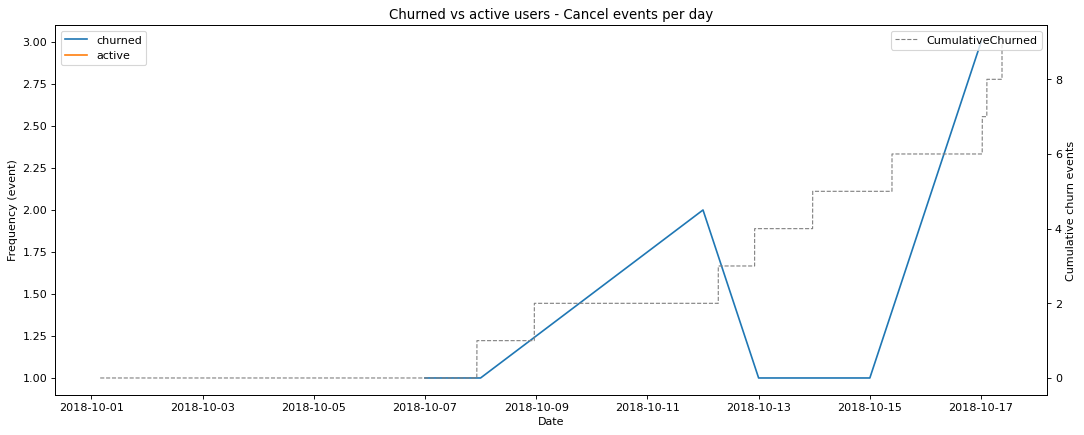

In [44]:
# number_of_songs_played_per_day(new_data_churn)
for pageEvent in unique_page_events:
    number_of_events_per_day(new_data_churn, pageEvent, True)

In [45]:
data_churn_hours, songs_in_hour = count_songs_in_hour(data_churn)
data_churn_hours.show(3)
songs_in_hour.show(3)

+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+----+
|          artist|gender|   length|level|            location|    page|             song|           ts|userId|churnedEvent|churnedUser|hour|
+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+----+
|  Martha Tilston|     M|277.89016| paid|     Bakersfield, CA|NextSong|        Rockpools|1538352117000|    30|           0|          0|   2|
|Five Iron Frenzy|     M|236.09424| free|Boston-Cambridge-...|NextSong|           Canada|1538352180000|     9|           0|          0|   2|
|    Adam Lambert|     M| 282.8273| paid|     Bakersfield, CA|NextSong|Time For Miracles|1538352394000|    30|           0|          0|   2|
+----------------+------+---------+-----+--------------------+--------+-----------------+-------------+------+------------+-----------+----+
only showing 

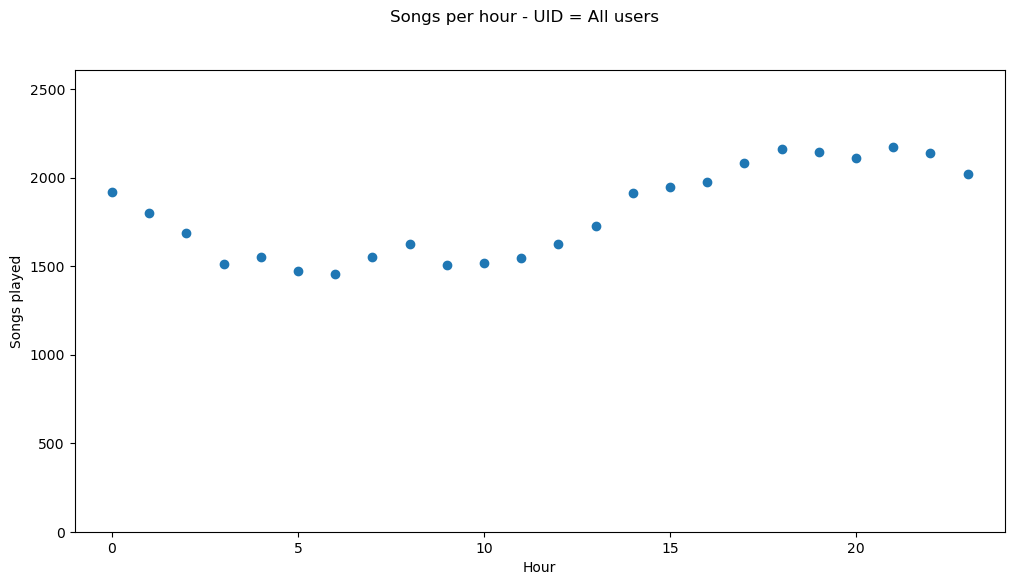

In [46]:
plot_number_of_songs_in_each_day_hour(songs_in_hour, 'All users')

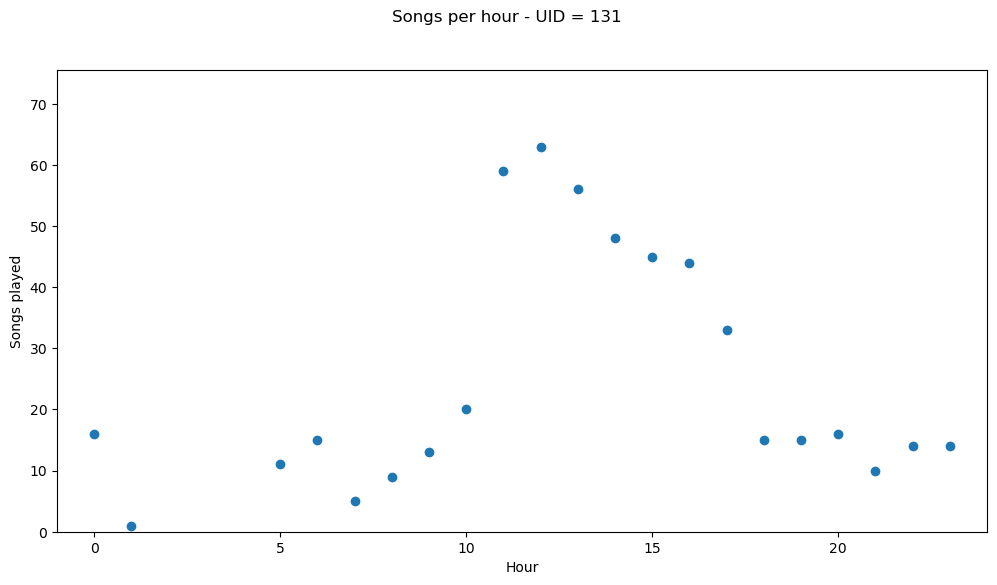

In [47]:
UID = 131 # User ID to create this plot for
_, songs_in_hour_per_user = count_songs_in_hour(data_churn[data_churn.userId == UID])
plot_number_of_songs_in_each_day_hour(songs_in_hour_per_user, UID)

In [48]:
data_churn[data_churn.churnedUser == 1].show()

+--------------------+------+---------+-----+--------------------+-----------+--------------------+-------------+------+------------+-----------+
|              artist|gender|   length|level|            location|       page|                song|           ts|userId|churnedEvent|churnedUser|
+--------------------+------+---------+-----+--------------------+-----------+--------------------+-------------+------+------------+-----------+
|                null|     M|     null| free|Denver-Aurora-Lak...|       Home|                null|1538358605000|   101|           0|          1|
|       The Cardigans|     M|198.21669| free|Denver-Aurora-Lak...|   NextSong|            Lovefool|1538358818000|   101|           0|          1|
|     Collective Soul|     M|273.47546| free|Denver-Aurora-Lak...|   NextSong|    Run (LP Version)|1538359016000|   101|           0|          1|
|    Dario Marianelli|     M|146.99057| free|Denver-Aurora-Lak...|   NextSong|        Cello Lesson|1538359289000|   101|    

+----+-----+
|hour|count|
+----+-----+
|   0|  177|
|   1|  205|
|   2|  192|
|   3|  195|
|   4|  219|
+----+-----+
only showing top 5 rows



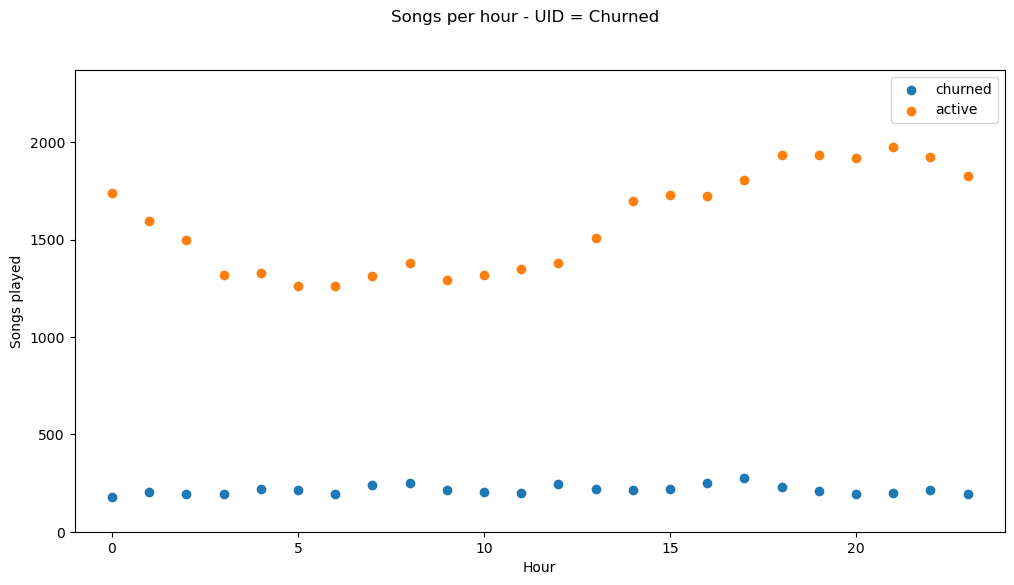

In [49]:
# Users that churned
_, songs_in_hour_for_churned = count_songs_in_hour(data_churn[data_churn.churnedUser == 1])
_, songs_in_hour_for_active = count_songs_in_hour(data_churn[data_churn.churnedUser == 0])
songs_in_hour_for_churned.show(5)
plot_number_of_songs_in_each_day_hour_churned_vs_active(songs_in_hour_for_churned, songs_in_hour_for_active, 'Churned')

In [50]:
data_churn_hours.select(["userId", "page", "hour"]).where(data_churn_hours.userId == 131).collect()

[Row(userId=131, page='NextSong', hour='10'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='11'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='Add to Playlist', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='NextSong', hour='12'),
 Row(userId=131, page='Help

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [146]:
data_features = data_churn.alias('data_features')
data_features = data_features.drop("artist", "location", "song", "userId", "churnedUser")
# data_features = data_features.drop("artist", "location", "song", "userId", "churnedEvent")
# data_features = data_features.withColumnRenamed('churnedUser', 'churnedEvent')

data_features.show()

+------+---------+-----+---------------+-------------+------------+
|gender|   length|level|           page|           ts|churnedEvent|
+------+---------+-----+---------------+-------------+------------+
|     M|277.89016| paid|       NextSong|1538352117000|           0|
|     M|236.09424| free|       NextSong|1538352180000|           0|
|     M| 282.8273| paid|       NextSong|1538352394000|           0|
|     M|262.71302| free|       NextSong|1538352416000|           0|
|     M|223.60771| paid|       NextSong|1538352676000|           0|
|     M|208.29995| free|       NextSong|1538352678000|           0|
|     M|260.46649| free|       NextSong|1538352886000|           0|
|     M|185.44281| paid|       NextSong|1538352899000|           0|
|     M|     null| paid|Add to Playlist|1538352905000|           0|
|     M|134.47791| paid|       NextSong|1538353084000|           0|
|     M| 229.8771| free|       NextSong|1538353146000|           0|
|     M|     null| free|    Roll Advert|15383531

In [147]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.functions import vector_to_array
import pyspark.sql.functions as F

indexer = StringIndexer(inputCol='gender', outputCol='male')
indexer_fitted = indexer.fit(data_features)
data_features = indexer_fitted.transform(data_features)
data_features = data_features.drop("gender")

indexer = StringIndexer(inputCol='level', outputCol='level_paid')
indexer_fitted = indexer.fit(data_features)
data_features = indexer_fitted.transform(data_features)
data_features = data_features.drop("level")

data_features.show()

+---------+---------------+-------------+------------+----+----------+
|   length|           page|           ts|churnedEvent|male|level_paid|
+---------+---------------+-------------+------------+----+----------+
|277.89016|       NextSong|1538352117000|           0| 1.0|       0.0|
|236.09424|       NextSong|1538352180000|           0| 1.0|       1.0|
| 282.8273|       NextSong|1538352394000|           0| 1.0|       0.0|
|262.71302|       NextSong|1538352416000|           0| 1.0|       1.0|
|223.60771|       NextSong|1538352676000|           0| 1.0|       0.0|
|208.29995|       NextSong|1538352678000|           0| 1.0|       1.0|
|260.46649|       NextSong|1538352886000|           0| 1.0|       1.0|
|185.44281|       NextSong|1538352899000|           0| 1.0|       0.0|
|     null|Add to Playlist|1538352905000|           0| 1.0|       0.0|
|134.47791|       NextSong|1538353084000|           0| 1.0|       0.0|
| 229.8771|       NextSong|1538353146000|           0| 1.0|       1.0|
|     

In [148]:
indexer = StringIndexer(inputCol='page', outputCol='page_numeric')
indexer_fitted = indexer.fit(data_features)
data_features = indexer_fitted.transform(data_features)
data_features = data_features.drop("page")

encoder = OneHotEncoder(inputCols=['page_numeric'], outputCols=['page_onehot'])
data_features = encoder.fit(data_features).transform(data_features)
data_features = data_features.drop("page_numeric")

data_features = data_features.select('*', vector_to_array('page_onehot').alias('col_onehot'))
data_features = data_features.drop("page_onehot")

num_categories = len(data_features.first()['col_onehot'])   # 3
cols_expanded = [(F.col('col_onehot')[i].alias(f'page_{indexer_fitted.labels[i]}')) for i in range(num_categories)]
data_features = data_features.select('*', *cols_expanded)
data_features = data_features.drop("col_onehot")
data_features.show()

+---------+-------------+------------+----+----------+-------------+--------------+---------+--------------------+----------------+---------------+-----------+----------------+--------------+-------------+---------+------------+----------+------------------+----------+-------------------+---------------------+-----------+
|   length|           ts|churnedEvent|male|level_paid|page_NextSong|page_Thumbs Up|page_Home|page_Add to Playlist|page_Roll Advert|page_Add Friend|page_Logout|page_Thumbs Down|page_Downgrade|page_Settings|page_Help|page_Upgrade|page_About|page_Save Settings|page_Error|page_Submit Upgrade|page_Submit Downgrade|page_Cancel|
+---------+-------------+------------+----+----------+-------------+--------------+---------+--------------------+----------------+---------------+-----------+----------------+--------------+-------------+---------+------------+----------+------------------+----------+-------------------+---------------------+-----------+
|277.89016|1538352117000|   

In [149]:
data_features = data_features.drop("ts")
print(data_features.count())
# data_features = data_features.na.drop(how='any') #, subset=['length'])
# print(data_features.count())
# output = output.where(output.length != "")
data_features.show()

52853
+---------+------------+----+----------+-------------+--------------+---------+--------------------+----------------+---------------+-----------+----------------+--------------+-------------+---------+------------+----------+------------------+----------+-------------------+---------------------+-----------+
|   length|churnedEvent|male|level_paid|page_NextSong|page_Thumbs Up|page_Home|page_Add to Playlist|page_Roll Advert|page_Add Friend|page_Logout|page_Thumbs Down|page_Downgrade|page_Settings|page_Help|page_Upgrade|page_About|page_Save Settings|page_Error|page_Submit Upgrade|page_Submit Downgrade|page_Cancel|
+---------+------------+----+----------+-------------+--------------+---------+--------------------+----------------+---------------+-----------+----------------+--------------+-------------+---------+------------+----------+------------------+----------+-------------------+---------------------+-----------+
|277.89016|           0| 1.0|       0.0|          1.0|          

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [150]:
# Taken from https://github.com/nirajpandkar/sparkify/blob/master/Sparkify.ipynb

def get_metrics(res, logger=False):
    """Given a results vector returns accuracy and f1-score"""
    total = res.count()
    
    tp = res.where((res.churnedEvent==1) & (res.prediction==1)).count()
    tn = res.where((res.churnedEvent==0) & (res.prediction==0)).count()
    
    fp = res.where((res.churnedEvent==0) & (res.prediction==1)).count()
    fn = res.where((res.churnedEvent==1) & (res.prediction==0)).count()

    if logger: 
        print('tp: ', round(tp, 4))
        print('tn: ', round(tn, 4))
        print('fp: ', round(fp, 4))
        print('fn: ', round(fn, 4))
        
    accuracy = (1.0*tp + tn) / total
    if (tp + fp) == 0: 
        precision = 0
    else:
        precision = 1.0*tp / (tp + fp)

    if (tp + fn) == 0: 
        recall = 0
    else:
        recall = 1.0*tp / (tp + fn)

    if (precision + recall) == 0:
        f1 = 0
    else:
        f1 = 2.0 * (precision * recall) / (precision + recall)
    
    print('Accuracy: ', round(accuracy, 4))
    print('Precision: ', round(precision, 4))
    print('Recall: ', round(recall, 4))
    print('F1-Score: ', round(f1, 4))

    return f1, accuracy

def plot_objective_history(model):
    # Obtain the objective per iteration
    model_summary = model.summary
    objectiveHistory = model_summary.objectiveHistory
    x_arr = np.arange(1, len(objectiveHistory) + 1)
    y_arr = objectiveHistory
    plt.plot(x_arr, y_arr)
    plt.xlabel('Iteration')
    plt.ylabel('Objective function value')
    plt.title('Objective function value vs iteration')
    plt.yscale('log')

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [175]:
assembler = VectorAssembler(inputCols = [\
    "male" , "level_paid" , "page_NextSong" , "page_Thumbs Up" , \
        "page_Home" , "page_Add to Playlist" , "page_Roll Advert" , \
            "page_Add Friend" , "page_Logout" , "page_Thumbs Down" , \
                "page_Downgrade" , "page_Settings" , "page_Help" , \
                    "page_Upgrade" , "page_About" , "page_Save Settings" , \
                        "page_Error" , "page_Submit Upgrade" , \
                            "page_Submit Downgrade" , "page_Cancel"
                            ], outputCol='features')
                           
output = assembler.transform(data_features)
# output.show()

In [180]:
finalised_data = output.select('features', 'churnedEvent')
# finalised_data.show()

In [183]:
train, test, validation = finalised_data.randomSplit([0.6, 0.2, 0.2], seed=100)
# train.show()

+--------------------+------------+
|            features|churnedEvent|
+--------------------+------------+
|      (20,[0],[1.0])|           1|
|      (20,[0],[1.0])|           1|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
|(20,[0,1,2],[1.0,...|           0|
+--------------------+------------+
only showing top 20 rows



# Logistic regression - baseline (with maxIter & regParam sensitivities)

Accuracy:  0.9999
Precision:  1.0
Recall:  0.5
F1-Score:  0.6667


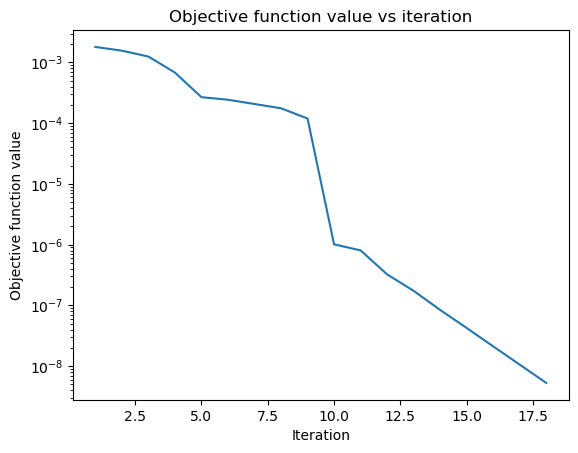

In [160]:
# Default parameterization
lr = LogisticRegression(labelCol="churnedEvent")
lr_model = lr.fit(train)
lr_prediction = lr_model.transform(test)
get_metrics(lr_prediction)
plot_objective_history(lr_model)


 ------> maxIter=2 & regParam=0.0
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  20.55495834350586

 ------> maxIter=2 & regParam=0.05
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  21.173426628112793

 ------> maxIter=2 & regParam=0.1
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  21.214738607406616

 ------> maxIter=2 & regParam=0.2
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  21.734246492385864

 ------> maxIter=5 & regParam=0.0
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  22.0499324798584

 ------> maxIter=5 & regParam=0.05
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  22.816915273666382

 ------> maxIter=5 & regParam=0.1
Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0
TOTAL time taken this loop:  23.593498468399048

 ------> maxI

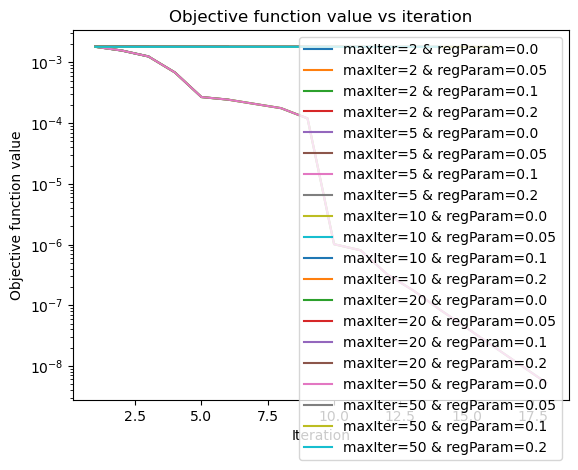

In [156]:
# maxIter & regParam sensitivities

maxIterList = [2, 5, 10, 20, 50]
regParamList = [0.0, 0.05, 0.1, 0.2] 
start = time.time()

reg_param_val_best = min(maxIterList)
max_iter_val_best = min(regParamList)
f1_list = []
accuracy_list = []
f1_max = 0.0
accuracy_at_f1max = 0
accuracy_max = 0
i_counter = 0
j_coutner = 0
for i in range(len(maxIterList)):
    max_iter_val = maxIterList[i]
    for j in range(len(regParamList)):
        startLoop = time.time()
        reg_param_val = regParamList[j]

        lr2 = LogisticRegression(labelCol="churnedEvent", maxIter = max_iter_val, regParam = reg_param_val)
        lr_model2 = lr2.fit(train)
        lr_prediction2 = lr_model2.transform(test)
        print(f'\n ------> maxIter={max_iter_val} & regParam={reg_param_val}')
        
        f1, accuracy = get_metrics(lr_prediction2)
        f1_list.append(f1)
        accuracy_list.append(accuracy)

        if f1 > f1_max:
            reg_param_val_best = reg_param_val
            max_iter_val_best = max_iter_val
            f1_max = f1
            accuracy_at_f1max = accuracy
        if accuracy > accuracy_max:
            accuracy_max = accuracy

        model_summary = lr_model2.summary
        objectiveHistory = model_summary.objectiveHistory
        x_arr = np.arange(1, len(objectiveHistory) + 1)
        y_arr = objectiveHistory
        plt.plot(x_arr, y_arr, label=f'maxIter={max_iter_val} & regParam={reg_param_val}')

        print("TOTAL time taken this loop: ", time.time() - startLoop)
        j_coutner += 1
    i_counter += 1

print("TOTAL time: ", time.time() - start)

plt.legend(loc='upper right')
plt.xlabel('Iteration')
plt.ylabel('Objective function value')
plt.title('Objective function value vs iteration')
plt.yscale('log')

In [161]:
print(f'Best f1 score = {f1_max}')
print(f'Best accuracy score = {accuracy_max}')

print(f'Best regParam value = {reg_param_val_best}')
print(f'Best maxIter value = {max_iter_val_best}')

Best f1 score = 0.6666666666666666
Best accuracy score = 0.9999047800418968
Best regParam value = 0.0
Best maxIter value = 10


# Test cross-validation

In [188]:
model_name = 'Logistic Regression'
numFolds = 2
lr = LogisticRegression(labelCol='churnedEvent', featuresCol='features')
evaluator = MulticlassClassificationEvaluator(labelCol = 'churnedEvent', metricName ='f1')
pipeline = Pipeline(stages=[lr])

lr_paramGrid = (ParamGridBuilder()
                .addGrid(lr.maxIter, [2, 5, 10, 20, 50])
                .addGrid(lr.regParam, [0.0, 0.05, 0.1, 0.2])
                .addGrid(lr.elasticNetParam, [0.1, 0.8, 0.99])
                .build()
            )

crossval = CrossValidator(
                        estimator=pipeline,
                        estimatorParamMaps=lr_paramGrid,
                        evaluator=evaluator,
                        numFolds=numFolds
                    )

lr_model = crossval.fit(train)

print('Logistic Regression results')
lr_results_valid = lr_model.transform(validation)
get_metrics(lr_results_valid)

Logistic Regression results
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1-Score:  1.0


(1.0, 1.0)

# Naive Bayes

In [189]:
dnb = NaiveBayes(labelCol="churnedEvent", featuresCol="features")
dnb_model = dnb.fit(train)
dnb_prediction = dnb_model.transform(test)
get_metrics(dnb_prediction)

Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0


(0, 0.9998095600837935)

# Decision Tree

In [190]:
dt = DecisionTreeClassifier(labelCol="churnedEvent", featuresCol="features")
dt_model = dt.fit(train)
dt_prediction = dt_model.transform(test)
get_metrics(dt_prediction)

Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0


(0, 0.9998095600837935)

# Random Forest

In [191]:
rf = RandomForestClassifier(labelCol="churnedEvent", featuresCol="features")
rf_model = rf.fit(train)
rf_prediction = rf_model.transform(test)
get_metrics(rf_prediction)

Accuracy:  0.9998
Precision:  0
Recall:  0.0
F1-Score:  0


(0, 0.9998095600837935)